In [296]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [297]:
%matplotlib inline

In [298]:
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import matplotlib.pyplot as plt

from bson.objectid import ObjectId

from sgmtradingcore.analytics.metrics import flat_capital_metrics
from stratagemdataprocessing.dbutils.mongo import MongoPersister

In [299]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (16, 8)

In [300]:
db = MongoPersister.init_from_config('backtesting', auto_connect=True)

In [301]:
name = 'coint'
desc = 'spread_extension'
code = 'ft12_ftps.nba'
mnemonic = 'ts.mmp_entryexit_stoploss'
trading_id = '562f5bef497aee1c22000001'
config_id = '5a0491ba9316de2a8719878e'

In [302]:
print 'Strategy name:', name
print 'Strategy desc:', desc
print 'Strategy code:', code
print 'Mnemonic:     ', mnemonic

Strategy name: coint
Strategy desc: spread_extension
Strategy code: ft12_ftps.nba
Mnemonic:      ts.mmp_entryexit_stoploss


In [303]:
from pprint import pprint
pprint(db['strategy_configurations'].find_one({'_id': ObjectId(config_id)}))

{u'_id': ObjectId('5a0491ba9316de2a8719878e'),
 u'params': {u'is_template_strategy': True,
             u'risk_controller': {u'component_name': u'PassAllRiskController',
                                  u'config': {},
                                  u'config_name': u'default'},
             u'scope_provider': {u'component_name': u'BasketballEventTradingScopeProvider',
                                 u'config': {u'competitions': [u'NBA']},
                                 u'config_name': u'nba'},
             u'signals_generators': [{u'component_name': u'CointegrationSignalGenerator',
                                      u'config': {u'interpolation_resolution': 10.0,
                                                  u'lookback_horizon': 1200.0,
                                                  u'pair_type': u'ft12_ftps',
                                                  u'trade_frequency': 60.0},
                                      u'config_name': u'ft12_ftps'}],
             u's

In [304]:
def to_dataframe(orders):
    settled = filter(lambda o: o['status_str'] == 'SETTLED', orders)

    cols = ['placed_time', 'pnl', 'size', 'bet_side', 'price', 'date_day', 'event_id', 'sticker', 'details']
    rcols = {'placed_time': 'dt', 'size': 'stake', 'price': 'odds', 'date_day': 'date'}

    df = pd.DataFrame(settled, columns=cols).rename(columns=rcols)

    df['is_back'] = (df['bet_side'] == 'back')
    df['capital'] = 10000
    df['reason'] = df['details'].apply(lambda d: d.get('reason'))
    df['pair_key'] = df['details'].apply(lambda d: tuple(d['pair_key']))
    df['portfolio_id'] = df['details'].apply(lambda d: d['portfolio_id'])
    df['plausible_returns'] = df['details'].apply(lambda d: d.get('plausible_returns', []))
    df['weight'] = df['details'].apply(lambda d: None if d['trade_intention']['name'] != 'OpenTradeSingleSticker' else d['signals'][0]['value'][d['trade_intention']['sticker']])

    del df['details']

    return df

rows = list(db['strategy_results'].find({
    'strategy_name': name,
    'strategy_desc': desc,
    'strategy_code': code,
#     'trading_user_id': trading_id,
    'mnemonic': mnemonic,
    'config_id': config_id
}))

df = pd.concat([
    to_dataframe(list(db['orders'].find({
        'strategy_result_id': str(r['_id'])
    }))) for r in rows if r['n_orders'] > 0
])

df['month'] = df.dt.dt.month

# Metrics:

In [305]:
flat_capital_metrics(df, groupby='month').T

month                                 1            2            3   \
n_trades                     2716.000000  1801.000000  2754.000000   
n_win                        1312.000000   889.000000  1358.000000   
n_loss                       1404.000000   912.000000  1396.000000   
hit_ratio                       0.483063     0.493615     0.493101   
average_trade_win               0.004364     0.004231     0.004126   
average_trade_loss              0.004537     0.004473     0.004582   
unitary_stake_return           -0.043410    -0.022667    -0.064592   
cr_trade                        0.898819     0.922096     0.875794   
cr_day                          0.164725     0.214509     0.172261   
cum_return                     -0.644558    -0.317766    -0.794563   
volatility (not annualised)     0.241200     0.116256     0.232259   
sharpe_ratio                   -2.672296    -2.733328    -3.421026   
maximum_drawdown               -0.633831    -0.324295    -0.824312   
drawdown_duration (days)       30.000000    25.000000    30.000000   
maximum_runup                   0.084492     0.073015     0.125338   
runup_duration (days)           3.000000     4.000000     4.000000   
total_pnl                   -6445.577208 -3177.663928 -7945.629644   
n_trading_days                 31.000000    22.000000    31.000000   

month                                 4           5           10  \
n_trades                     2034.000000  185.000000  593.000000   
n_win                         993.000000   84.000000  287.000000   
n_loss                       1041.000000  101.000000  306.000000   
hit_ratio                       0.488201    0.454054    0.483980   
average_trade_win               0.004593    0.003956    0.004341   
average_trade_loss              0.004826    0.004097    0.004358   
unitary_stake_return            0.016861   -0.232476   -0.052967   
cr_trade                        0.907873    0.803194    0.934407   
cr_day                          0.188985    0.251599    0.501912   
cum_return                     -0.462802   -0.081433   -0.087463   
volatility (not annualised)     0.142372    0.044417    0.139086   
sharpe_ratio                   -3.250648   -1.833356   -0.628837   
maximum_drawdown               -0.381719   -0.084844   -0.063729   
drawdown_duration (days)       29.000000   22.000000    1.000000   
maximum_runup                   0.112322    0.015767    0.059709   
runup_duration (days)           6.000000    4.000000    1.000000   
total_pnl                   -4628.018475 -814.326226 -874.626679   
n_trading_days                 28.000000   14.000000    6.000000   

month                                  11           12  
n_trades                      3129.000000  2844.000000  
n_win                         1469.000000  1412.000000  
n_loss                        1660.000000  1432.000000  
hit_ratio                        0.469479     0.496484  
average_trade_win                0.004215     0.004156  
average_trade_loss               0.004545     0.004490  
unitary_stake_return            -0.127448    -0.050884  
cr_trade                         0.820693     0.912758  
cr_day                           0.047277     0.220816  
cum_return                      -1.352708    -0.560949  
volatility (not annualised)      0.478710     0.176282  
sharpe_ratio                    -2.825738    -3.182112  
maximum_drawdown                -1.390465    -0.577731  
drawdown_duration (days)        25.000000    30.000000  
maximum_runup                   -0.088538     0.087089  
runup_duration (days)            1.000000     2.000000  
total_pnl                   -13527.078117 -5609.486958  
n_trading_days                  30.000000    31.000000

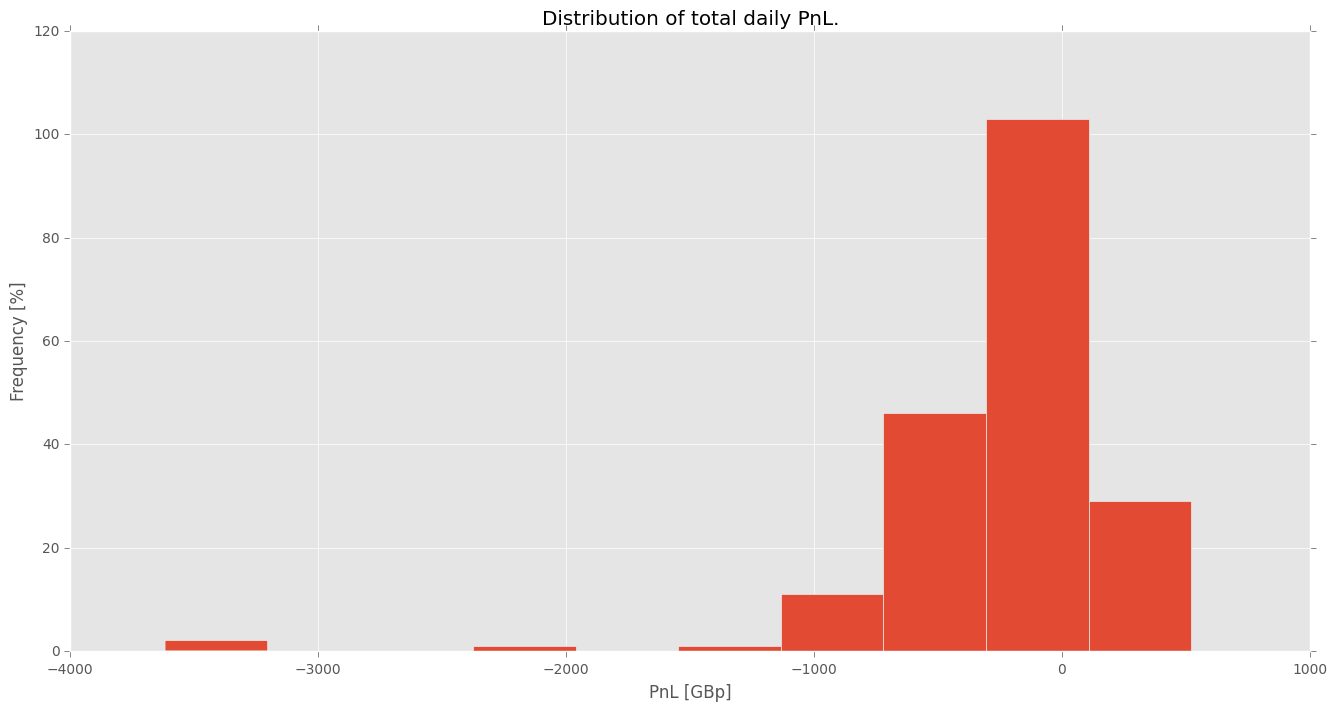

In [306]:
flat_capital_metrics(df, groupby='date')['total_pnl'].hist()
plt.title('Distribution of total daily PnL.')
plt.xlabel('PnL [GBp]')
_ = plt.ylabel('Frequency [%]')

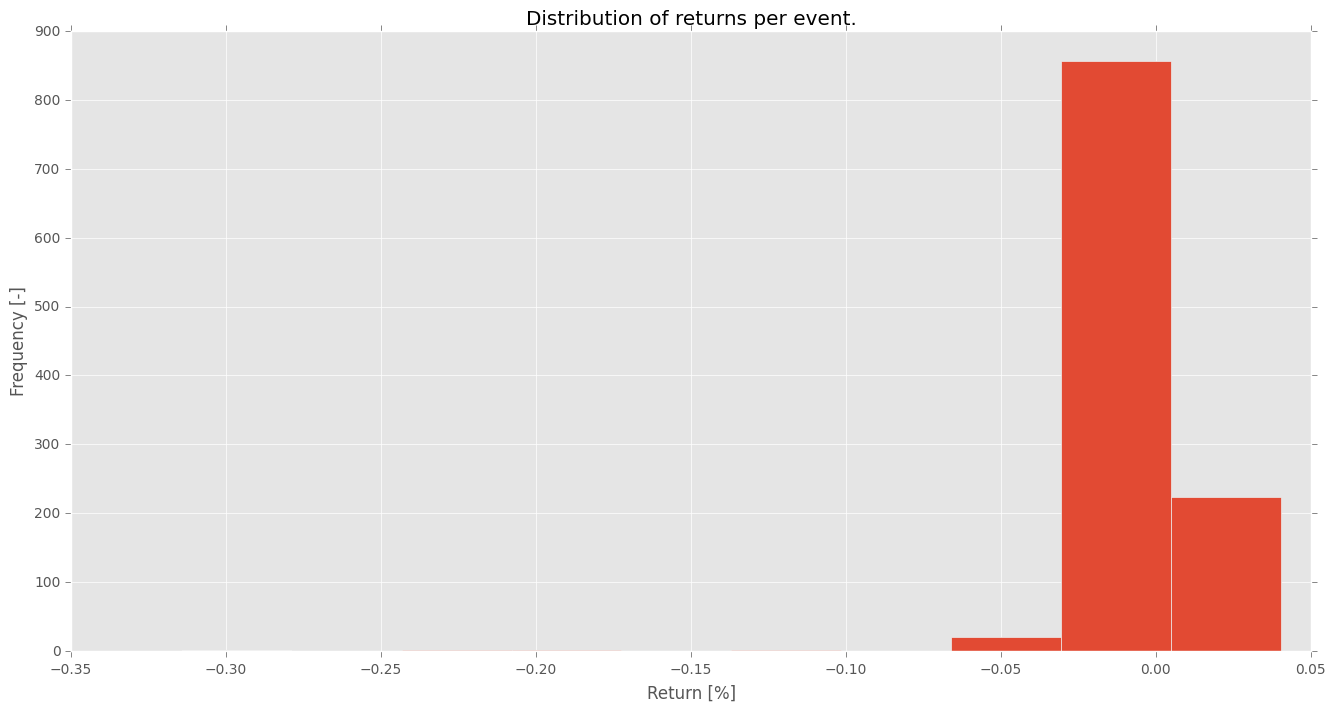

In [307]:
flat_capital_metrics(df, groupby='event_id')['cum_return'].hist()
plt.title('Distribution of returns per event.')
plt.xlabel('Return [%]')
_ = plt.ylabel('Frequency [-]')

# Portfolio-based analysis:

Let a portfolio, $\Pi_i$, be the set of trades associated with a given signal to take a position on $n > 0$ markets. Each portfolio will typically comprise $2n$ trades (for each market we have one trade to open and one to close), though it need only have 1 actual trade to be valid. We define the following properties:

- __PnL__ - The total accumulated profit and loss for the portfolio, starting from the opening time, $t_0^{(i)}$, up to the closing time, $T^{(i)}$.
- __Age__ - The total time (in seconds) that the portfolio was held open in the $n$ markets: $T^{(i)} - t_0^{(i)}$.
- __Reason__ - The cause for closing the portfolio.

In [308]:
pdf = pd.DataFrame(columns=['portfolio_id', 'pnl', 'age', 'reason']).set_index('portfolio_id')
gps = df.groupby('portfolio_id')

for g in gps.groups:
    gp = gps.get_group(g).sort_values('dt')
    pdf.loc[g] = [gp.pnl.sum(), (gp.iloc[-1]['dt'] - gp.iloc[0]['dt']).total_seconds(), gp.iloc[-1].reason]

pdf['age'] = pdf['age'].astype(np.int)
pdf.loc[pd.isnull(pdf.reason), 'reason'] = 'unclosed'

In [309]:
pdf.describe().T

count         mean          std          min        25%        50%  \
pnl  4241.0   -10.144402    82.966882 -3015.421645 -43.584567   -8.81983   
age  4241.0  1489.328932  1791.485695     0.000000   0.000000  752.00000   

             75%      max  
pnl    16.194415   307.54  
age  2463.000000  9604.00

In [310]:
print 'Minimum PnL:'
worst_portfolio = pdf[pdf.pnl == pdf.pnl.min()].index[0]
pd.DataFrame(pdf.loc[worst_portfolio]).T

Minimum PnL:


pnl   age              reason
5a04a20e9316de40b7d84d9f -3015.42  5523  portfolio_conflict

In [311]:
df[df.portfolio_id == worst_portfolio].sort_values('dt').T

56  \
dt                                  2016-11-13 01:22:08.891000+00:00   
pnl                                                           83.025   
stake                                                           61.5   
bet_side                                                        back   
odds                                                            2.35   
date                                                      2016-11-13   
event_id                                                  ENP2352960   
sticker                                   BB-EENP2352960-FTPS-1-n5_5   
is_back                                                         True   
capital                                                        10000   
reason                                                          None   
pair_key           (BB-EENP2352960-FT12-2.BF, BB-EENP2352960-FTPS...   
portfolio_id                                5a04a20e9316de40b7d84d9f   
plausible_returns                                                 []   
weight                                                     -0.615004   
month                                                             11   
liability                                                       61.5   

                                                                  82  \
dt                                  2016-11-13 01:22:08.891000+00:00   
pnl                                                             38.5   
stake                                                           38.5   
bet_side                                                         lay   
odds                                                            3.27   
date                                                      2016-11-13   
event_id                                                  ENP2352960   
sticker                                        BB-EENP2352960-FT12-2   
is_back                                                        False   
capital                                                        10000   
reason                                                          None   
pair_key           (BB-EENP2352960-FT12-2.BF, BB-EENP2352960-FTPS...   
portfolio_id                                5a04a20e9316de40b7d84d9f   
plausible_returns                                                 []   
weight                                                      0.384996   
month                                                             11   
liability                                                     87.395   

                                                                  38  \
dt                                  2016-11-13 02:54:12.810000+00:00   
pnl                                                         -3136.82   
stake                                                        89.6234   
bet_side                                                         lay   
odds                                                              36   
date                                                      2016-11-13   
event_id                                                  ENP2352960   
sticker                                   BB-EENP2352960-FTPS-1-n5_5   
is_back                                                        False   
capital                                                        10000   
reason                                            portfolio_conflict   
pair_key           (BB-EENP2352960-FT12-2.BF, BB-EENP2352960-FTPS...   
portfolio_id                                5a04a20e9316de40b7d84d9f   
plausible_returns  [0.0, 0.0, 0.00699992816698, 0.00699992816698,...   
weight                                                           NaN   
month                                                             11   
liability                                                    3136.82   

                                                                  68  
dt                                  2016-11-13 02:54:12.810000+00:00  
pnl                              

In [312]:
print 'Maxmimum PnL:'
best_portfolio = pdf[pdf.pnl == pdf.pnl.max()].index[0]
pd.DataFrame(pdf.loc[best_portfolio]).T

Maxmimum PnL:


pnl age    reason
5a04b1fc9316de40b7e36dc2  307.54   0  unclosed

In [313]:
df[df.portfolio_id == best_portfolio].sort_values('dt').T

43  \
dt                                  2017-02-07 02:54:21.765000+00:00   
pnl                                                           -10.01   
stake                                                             13   
bet_side                                                         lay   
odds                                                            1.77   
date                                                      2017-02-07   
event_id                                                  ENP2353598   
sticker                                    BB-EENP2353598-FTPS-2-1_5   
is_back                                                        False   
capital                                                        10000   
reason                                                          None   
pair_key           (BB-EENP2353598-FT12-2.BF, BB-EENP2353598-FTPS...   
portfolio_id                                5a04b1fc9316de40b7e36dc2   
plausible_returns                                                 []   
weight                                                      0.129952   
month                                                              2   
liability                                                      10.01   

                                                                  52  
dt                                  2017-02-07 02:54:21.765000+00:00  
pnl                                                           317.55  
stake                                                             87  
bet_side                                                        back  
odds                                                            4.65  
date                                                      2017-02-07  
event_id                                                  ENP2353598  
sticker                                        BB-EENP2353598-FT12-2  
is_back                                                         True  
capital                                                        10000  
reason                                                          None  
pair_key           (BB-EENP2353598-FT12-2.BF, BB-EENP2353598-FTPS...  
portfolio_id                                5a04b1fc9316de40b7e36dc2  
plausible_returns                                                 []  
weight                                                     -0.870048  
month                                                              2  
liability                                                         87

In [314]:
pnl_out_lim = pdf.pnl.quantile(0.005)

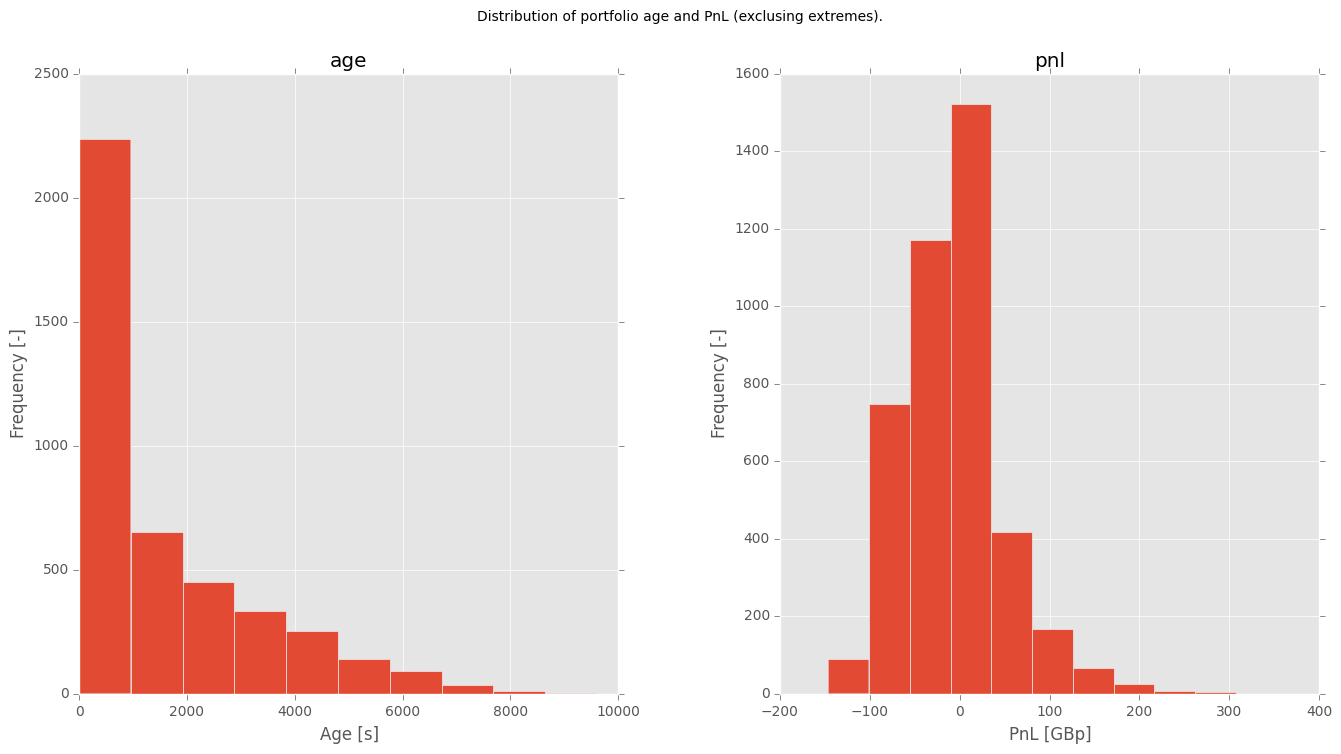

In [315]:
axes = pdf[pdf.pnl > pnl_out_lim][['pnl', 'age']].hist()[0]
plt.suptitle('Distribution of portfolio age and PnL (exclusing extremes).')

axes[0].set_xlabel('Age [s]')
axes[0].set_ylabel('Frequency [-]')

axes[1].set_xlabel('PnL [GBp]')
_ = axes[1].set_ylabel('Frequency [-]')

/home/tspooner/.venv/st/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/home/tspooner/.venv/st/lib/python2.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


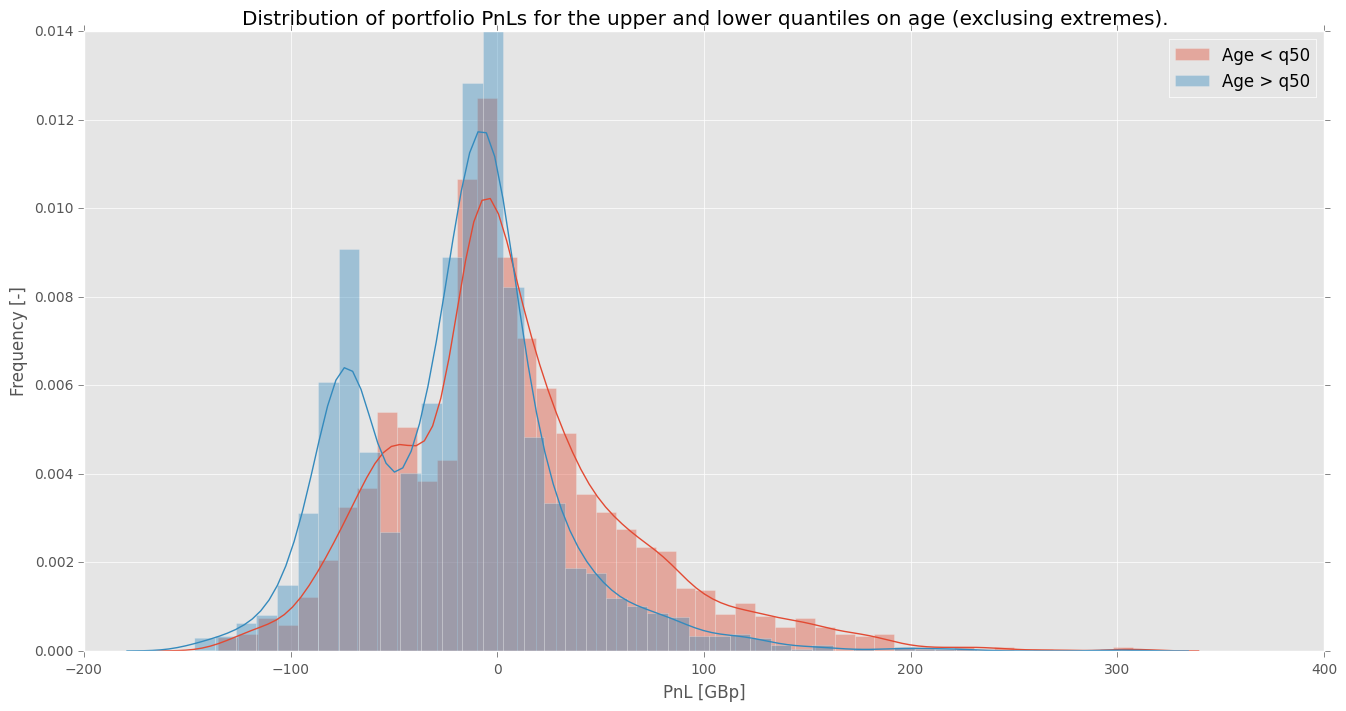

In [316]:
sns.distplot(pdf[pdf.pnl > pnl_out_lim][pdf.age < pdf.age.quantile(0.50)]['pnl'])
sns.distplot(pdf[pdf.pnl > pnl_out_lim][pdf.age > pdf.age.quantile(0.50)]['pnl'])
plt.legend(['Age < q50', 'Age > q50'])

plt.title('Distribution of portfolio PnLs for the upper and lower quantiles on age (exclusing extremes).')
plt.xlabel('PnL [GBp]')
_ = plt.ylabel('Frequency [-]')

In [317]:
df.groupby('reason')['pnl'].describe().T

reason                   
portfolio_conflict  count    6199.000000
                    mean       -8.362165
                    std        83.676836
                    min     -3420.047914
                    25%       -31.947434
                    50%        -0.435823
                    75%        22.588489
                    max       827.811600
sl/tp               count    1375.000000
                    mean       -9.212505
                    std        47.010472
                    min      -386.654709
                    25%        -0.678120
                    50%         0.974124
                    75%        10.395338
                    max       130.880523
Name: pnl, dtype: float64

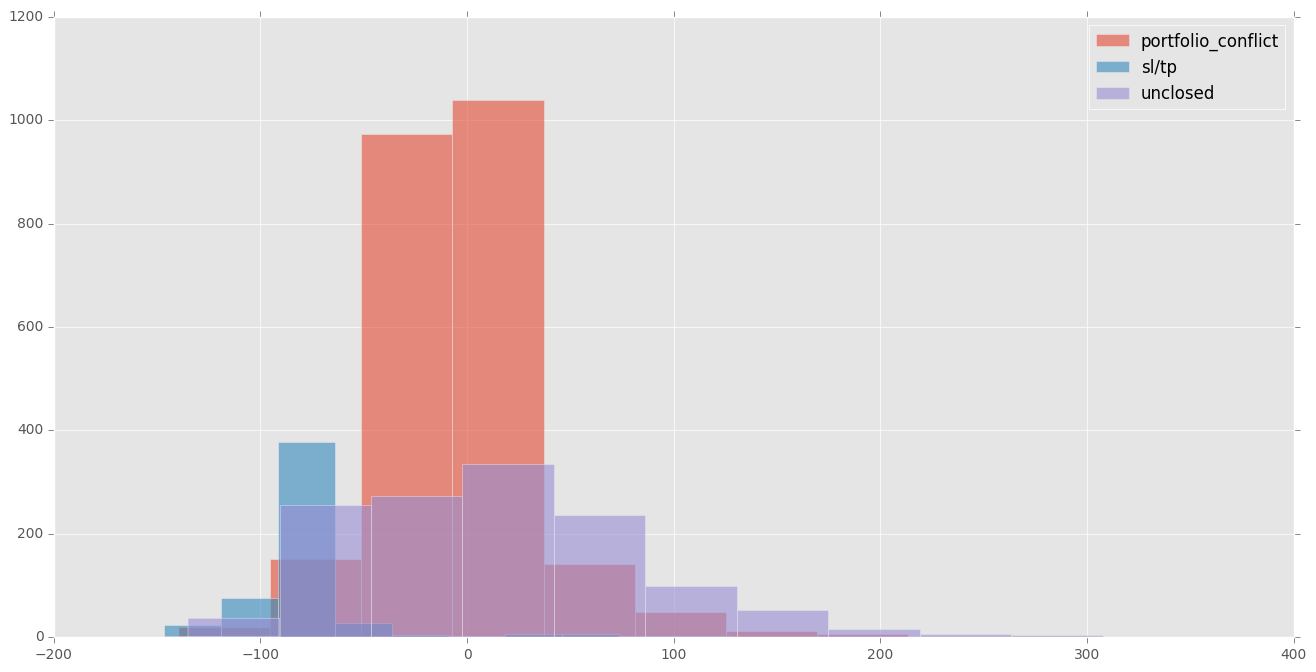

In [318]:
f, ax = plt.subplots(1)
gps = pdf[pdf.reason.values != None][pdf.pnl > pnl_out_lim].groupby('reason')

for gid, gp in gps:
    gp.pnl.hist(alpha=0.6, label=gid)

_ = plt.legend()

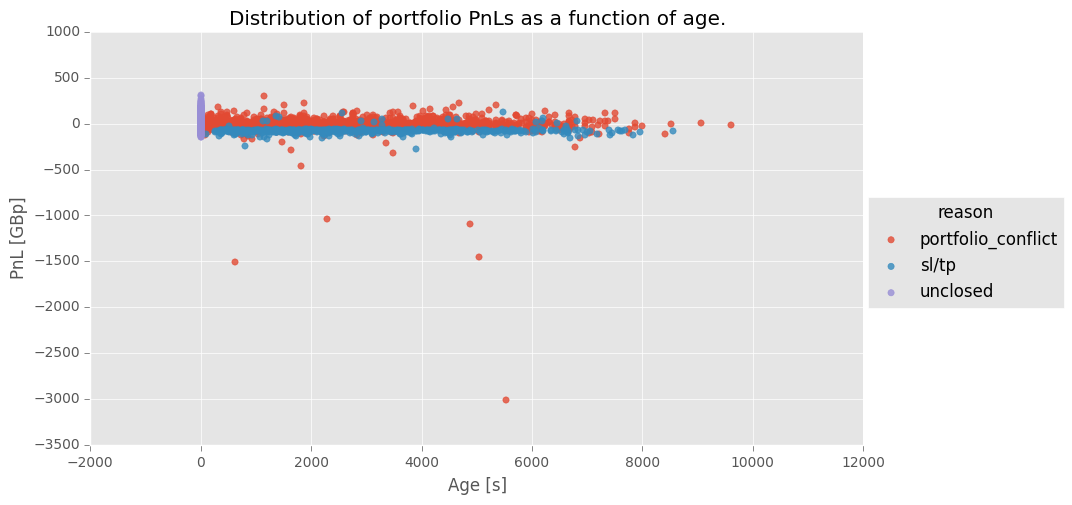

In [319]:
sns.lmplot("age", "pnl", data=pdf, hue="reason", fit_reg=False, aspect=1.8)
plt.title('Distribution of portfolio PnLs as a function of age.')
plt.xlabel('Age [s]')
_ = plt.ylabel('PnL [GBp]')

### Best/worst case analysis:

In [320]:
def get_ret(gp, f=lambda vs: vs[-1]):
    prs = gp.sort_values('dt')['plausible_returns'].values
    lens = map(len, prs)
    ix = np.argmax(lens)

    if any(l > 0 for l in lens):
        return f(prs[ix])
    else:
        return 0.0

In [321]:
get_best_ret = lambda gp: get_ret(gp, lambda vs: max(vs))
get_worst_ret = lambda gp: get_ret(gp, lambda vs: min(vs))

In [322]:
gps = df.groupby('portfolio_id')
actual_rets = gps.apply(get_ret)
best_rets = gps.apply(get_best_ret)
worst_rets = gps.apply(get_worst_ret)

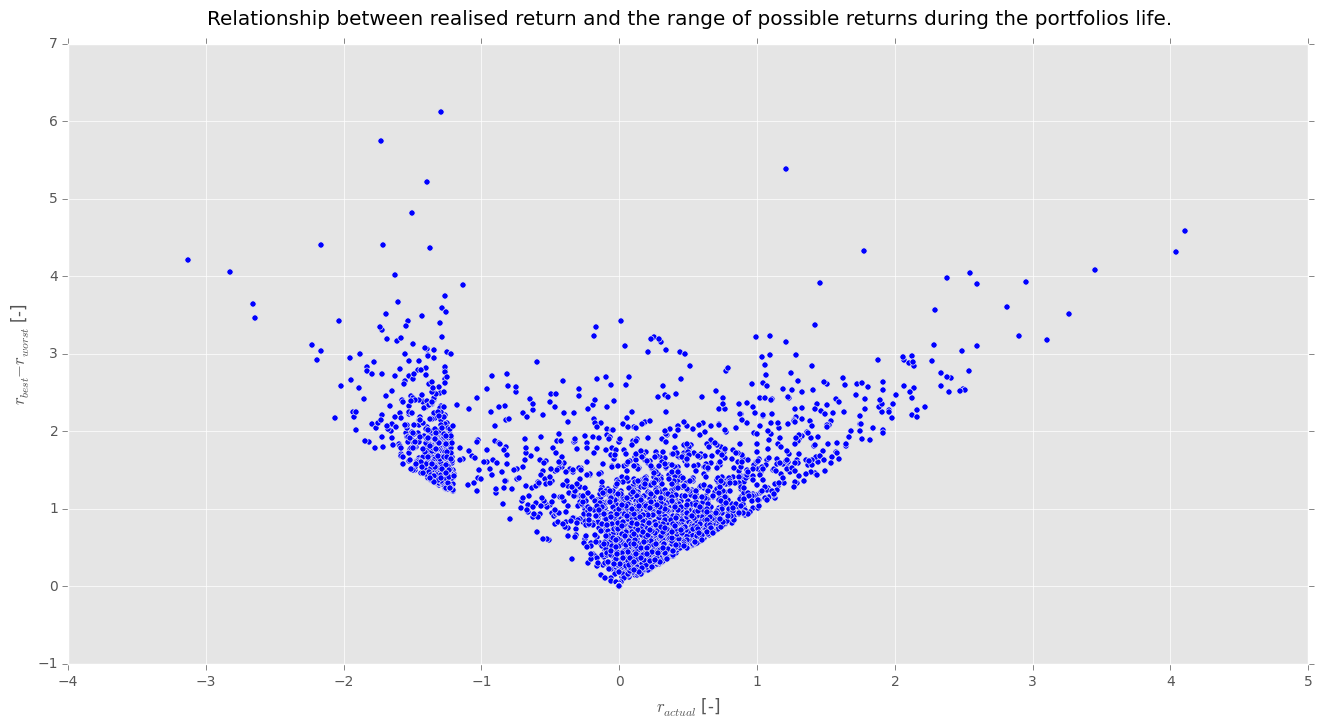

In [323]:
plt.scatter(actual_rets, best_rets-worst_rets)
plt.xlabel('$r_{actual}$ [-]')
plt.ylabel('$r_{best} - r_{worst}$ [-]')
_ = plt.title('Relationship between realised return and the range of possible returns during the portfolios life.', y=1.02)

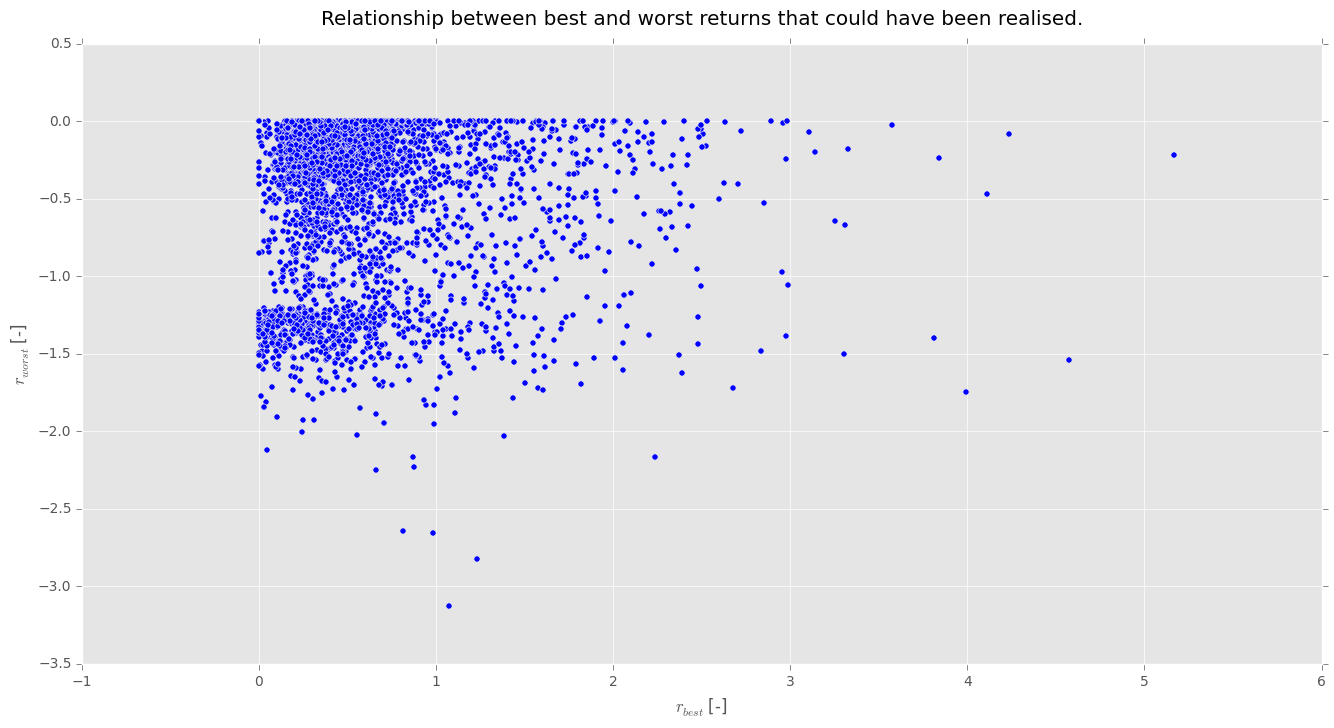

In [324]:
plt.scatter(best_rets, worst_rets)
plt.xlabel('$r_{best}$ [-]')
plt.ylabel('$r_{worst}$ [-]')
_ = plt.title('Relationship between best and worst returns that could have been realised.', y=1.02)

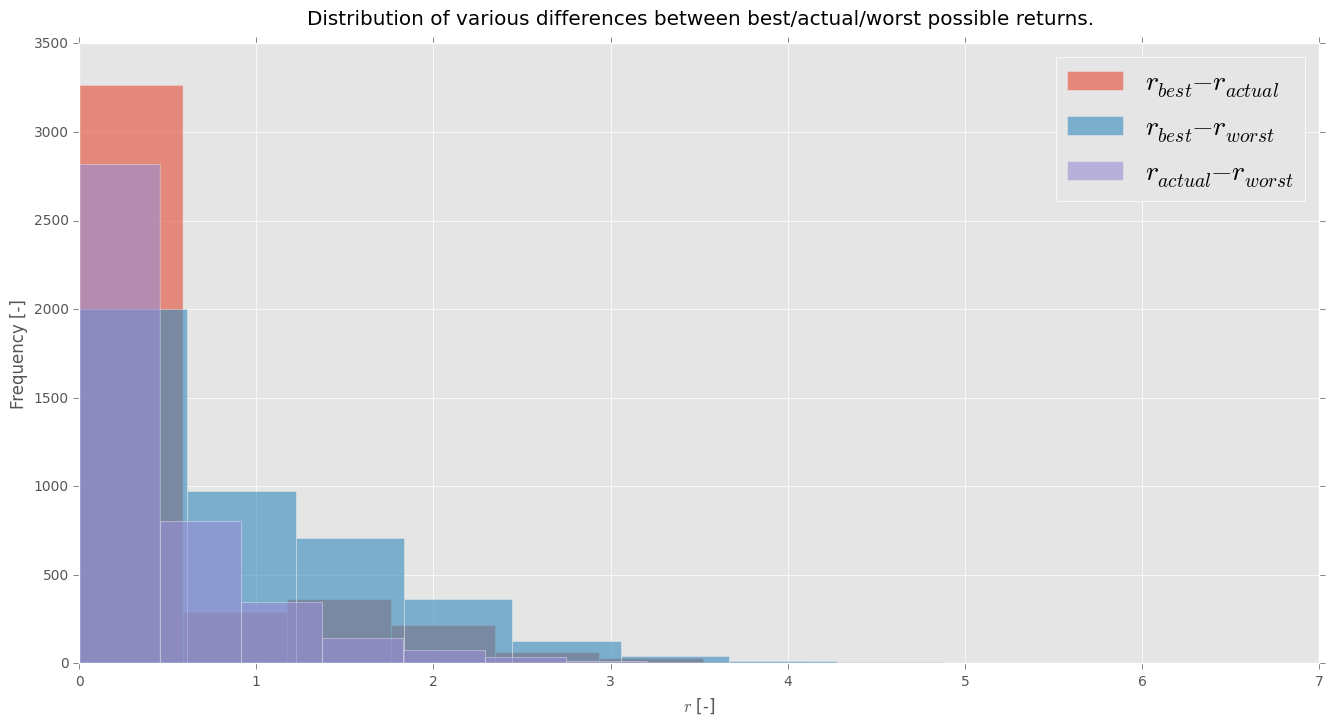

In [325]:
(best_rets-actual_rets).hist(alpha=0.6)
(best_rets-worst_rets).hist(alpha=0.6)
(actual_rets-worst_rets).hist(alpha=0.6)

plt.xlabel('$r$ [-]')
plt.ylabel('Frequency [-]')
plt.title('Distribution of various differences between best/actual/worst possible returns.', y=1.02)
_ = plt.legend(['$r_{best} - r_{actual}$', '$r_{best} - r_{worst}$', '$r_{actual} - r_{worst}$'], loc='best', prop={'size': 20})

# Time series:

In [326]:
def load_df(s):
    from sgmarb.backtesting.data import clean_dataframe
    from stratagemdataprocessing.bookmakers.common.odds.cache import HistoricalOddsCache

    hoc = HistoricalOddsCache(parse=False)
    sdf = clean_dataframe(hoc.get('%s.BF' % s), min_matched=0)
    if sdf is not None:
        sdf['timestamp'] = pd.to_datetime(sdf.timestamp, unit='ms')
        return sdf.set_index('timestamp')
    else:
        return None

In [327]:
def do_plot(pk):
    edf = df[df.pair_key == pk].sort_values('dt')
    stickers = edf['sticker'].unique()

    sdfs = {s: load_df(s) for s in stickers}
    sdfs = {s: df for (s, df) in sdfs.iteritems() if df is not None}

    f, axes = plt.subplots(len(sdfs), sharex=True, figsize=(16, 4*len(sdfs)))
    plt.suptitle(pk)

    for i, (s, sdf) in enumerate(sdfs.iteritems()):
        mp = (sdf['bp1'] + sdf['lp1']) / 2.0
        axes[i].plot(sdf.index, mp, drawstyle='steps-post', color='k', alpha=0.5)
        axes[i].set_title(s)
        axes[i].set_ylim([1.0, min(10.0, mp.max()*1.1)])

        for pid, p in edf[edf.sticker == s].groupby('portfolio_id'):
            open_dt = p['dt'].min()
            close_dt = p['dt'].max()

            if p[p.dt == open_dt].iloc[0].is_back:
                axes[i].axvspan(open_dt, close_dt, color='red', alpha=0.1, label='Back')
            else:
                axes[i].axvspan(open_dt, close_dt, color='blue', alpha=0.1, label='Lay')

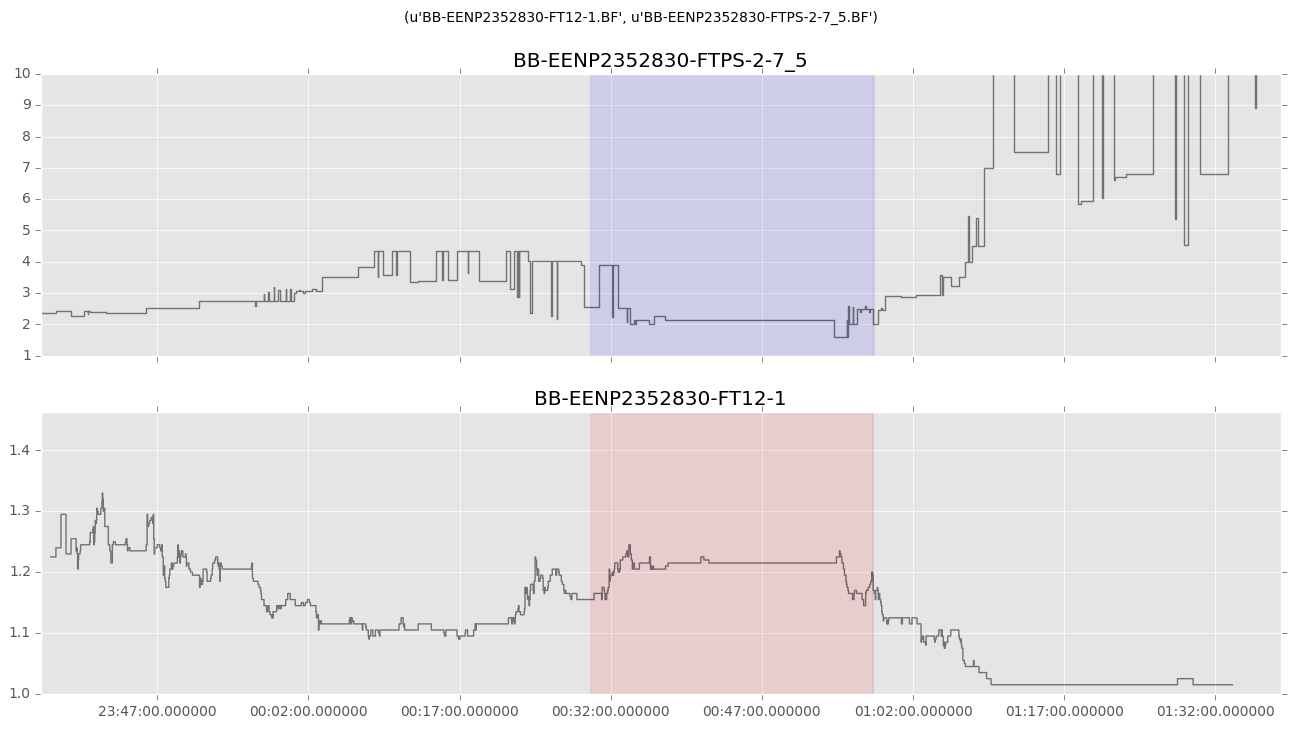

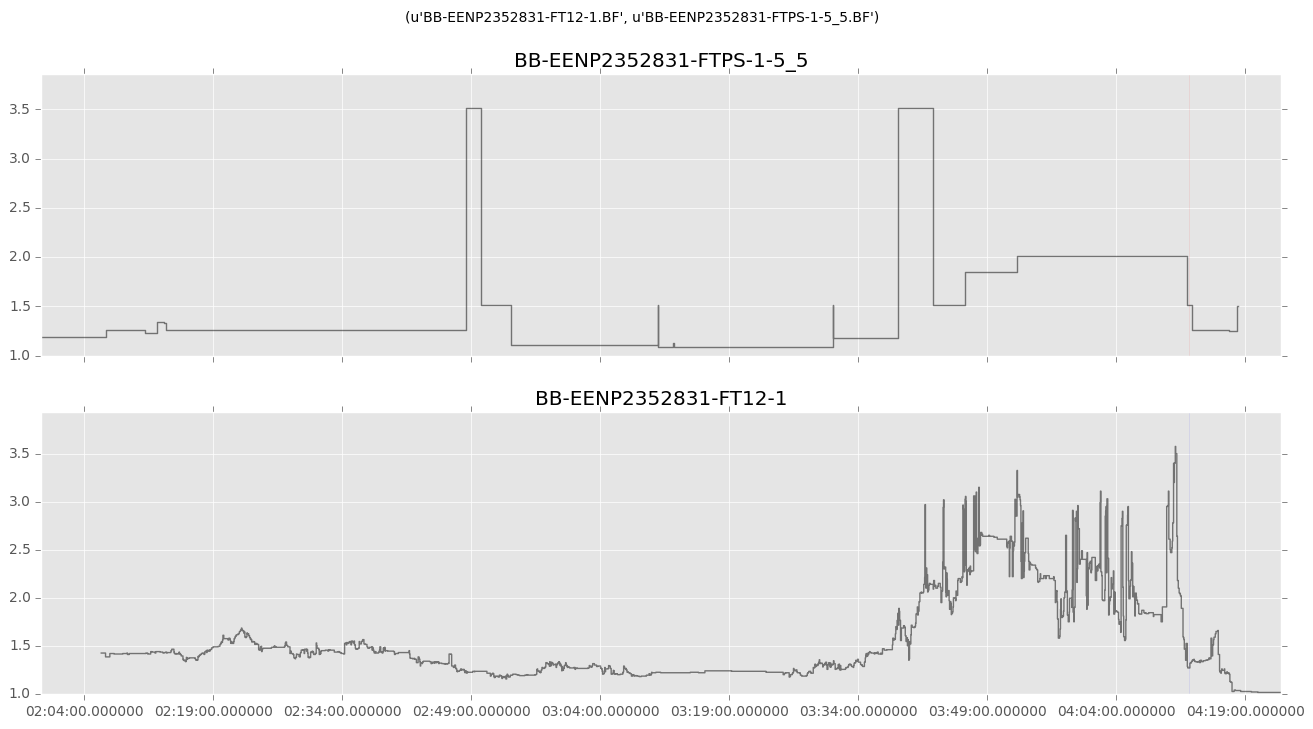

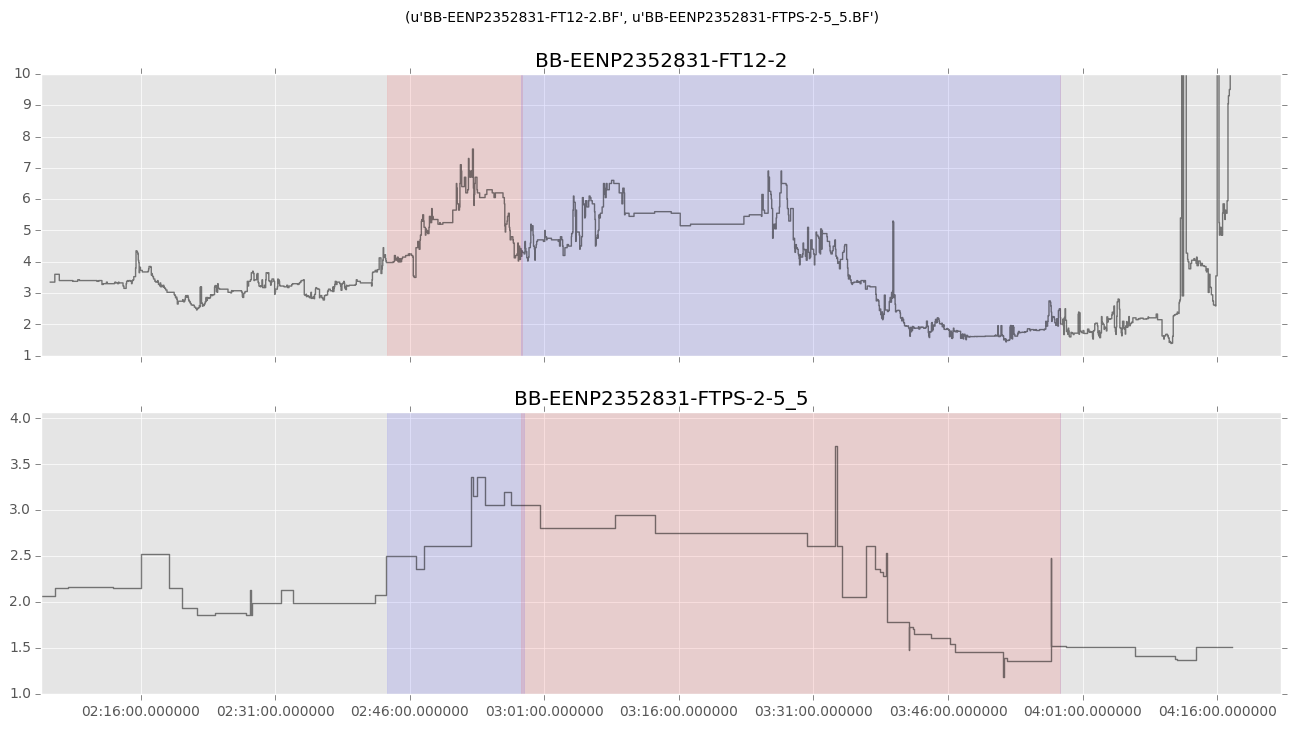

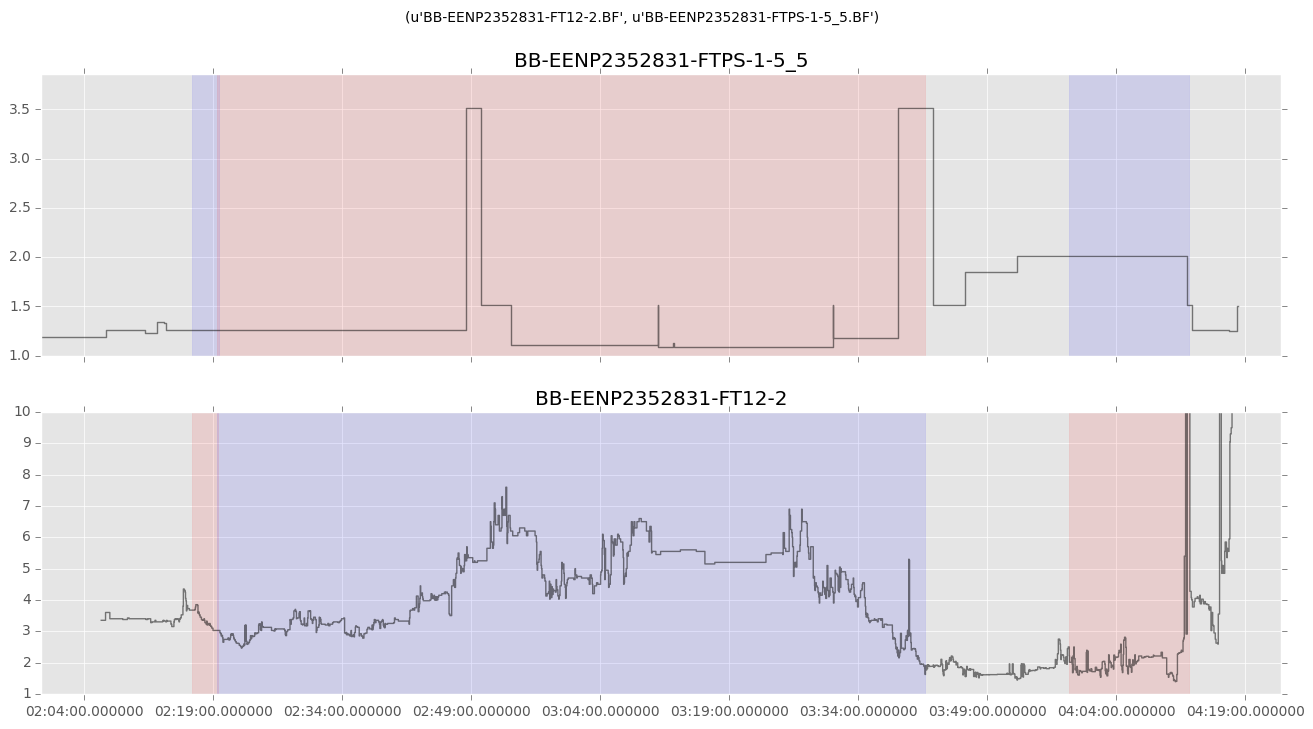

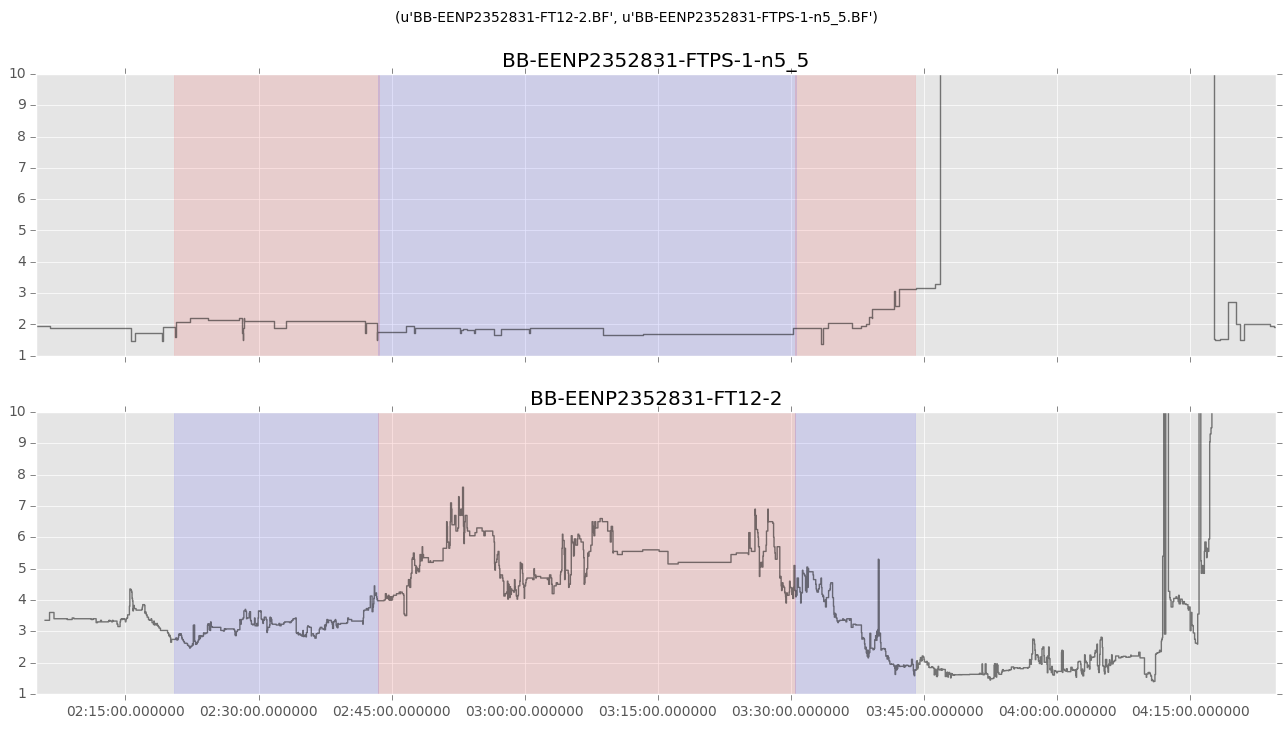

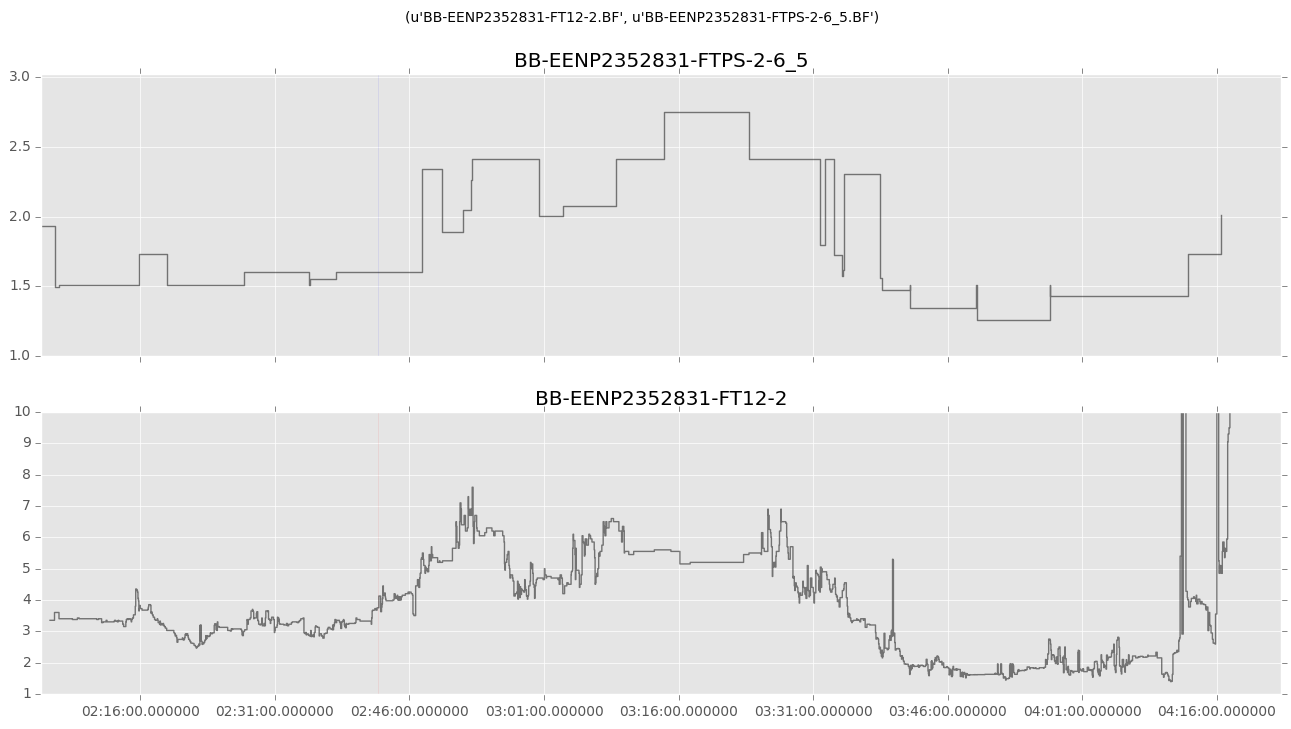

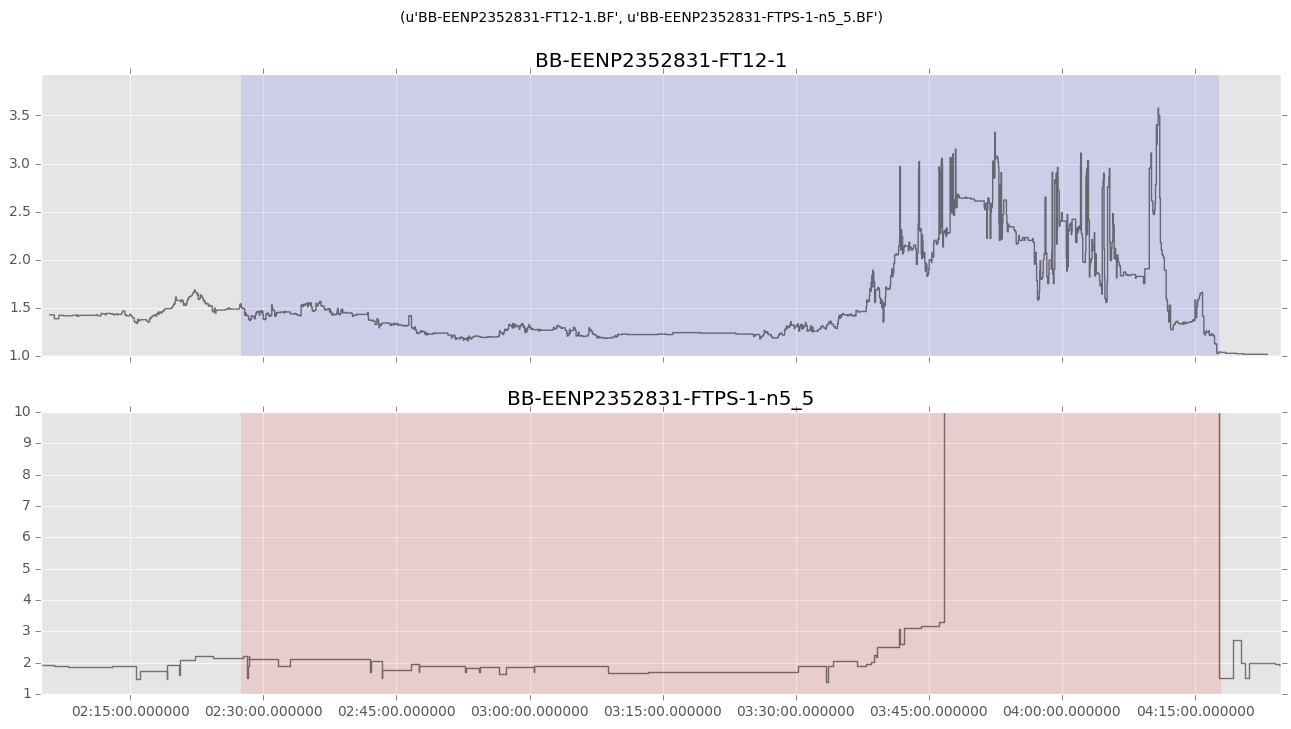

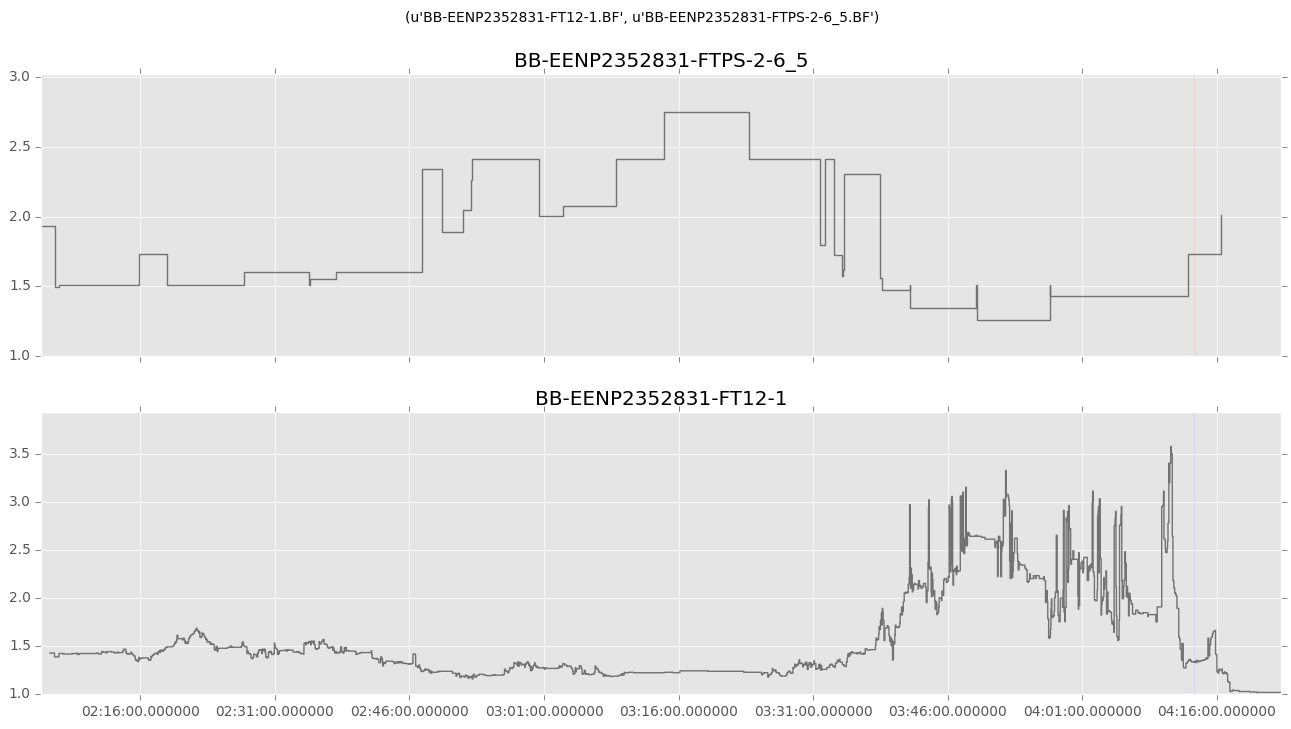

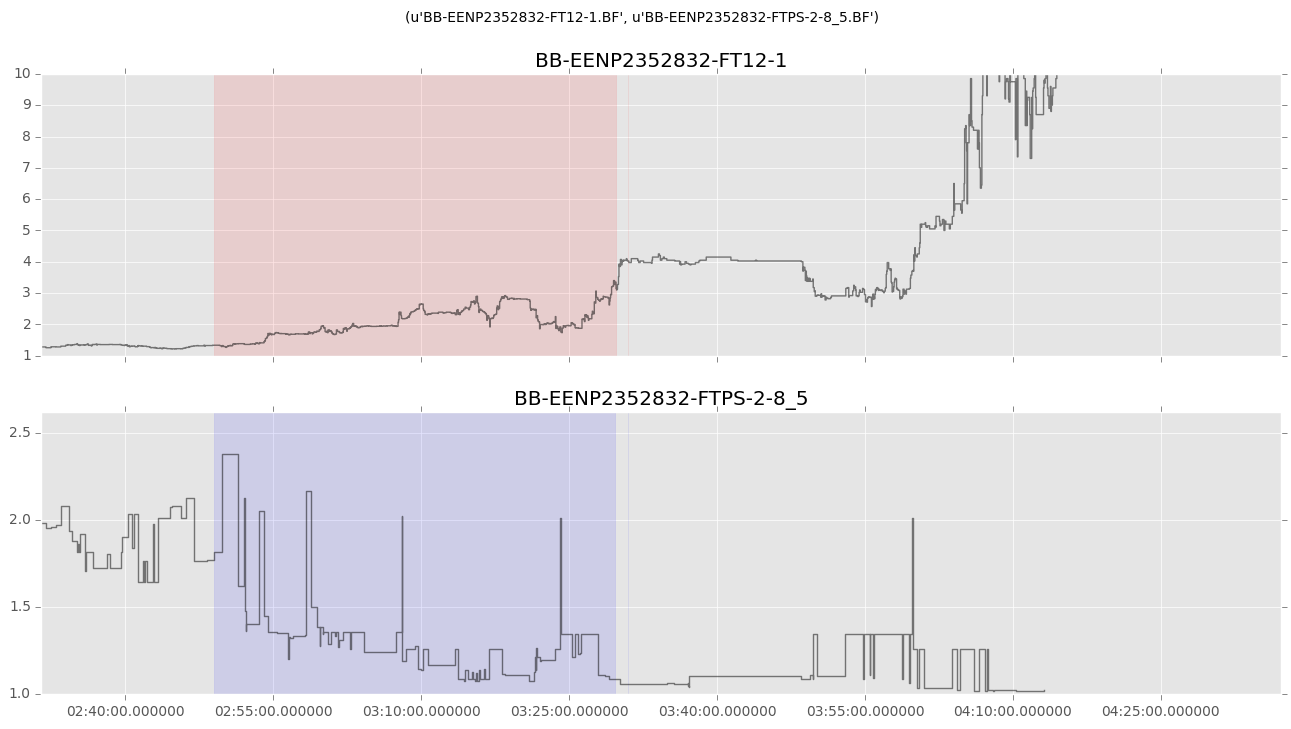

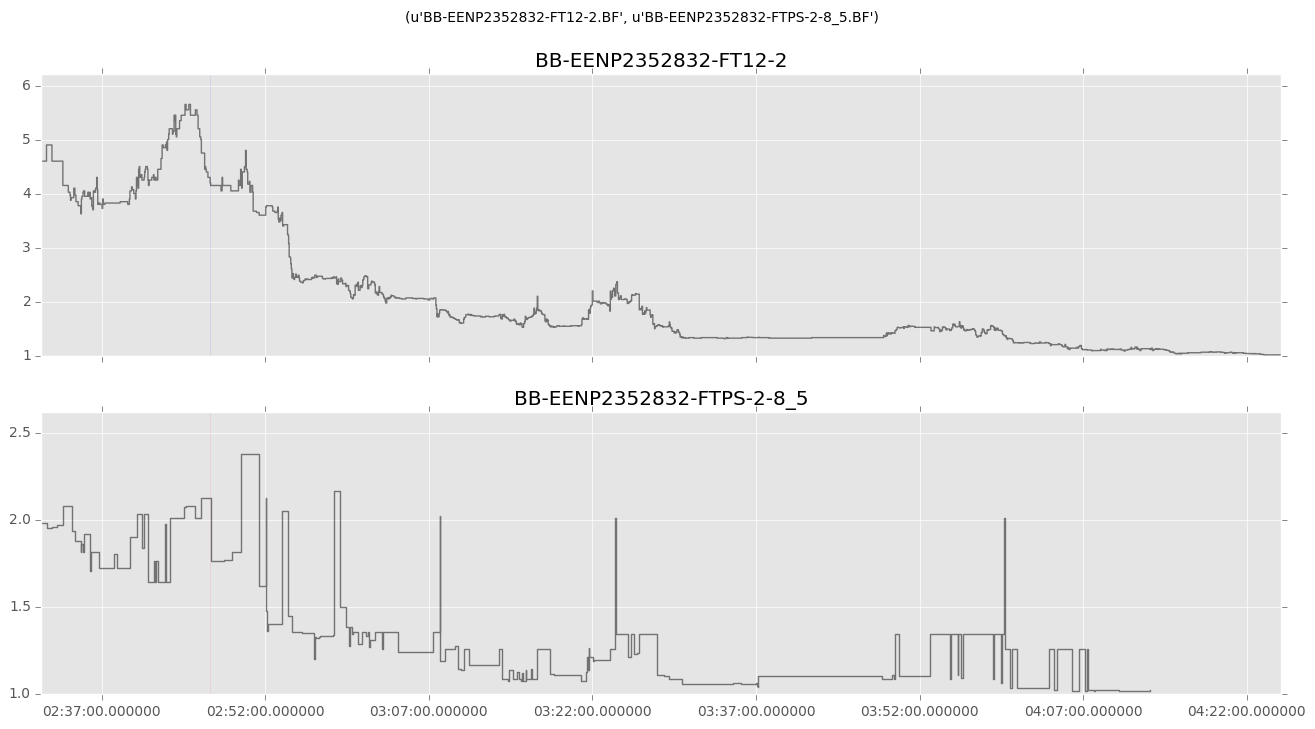

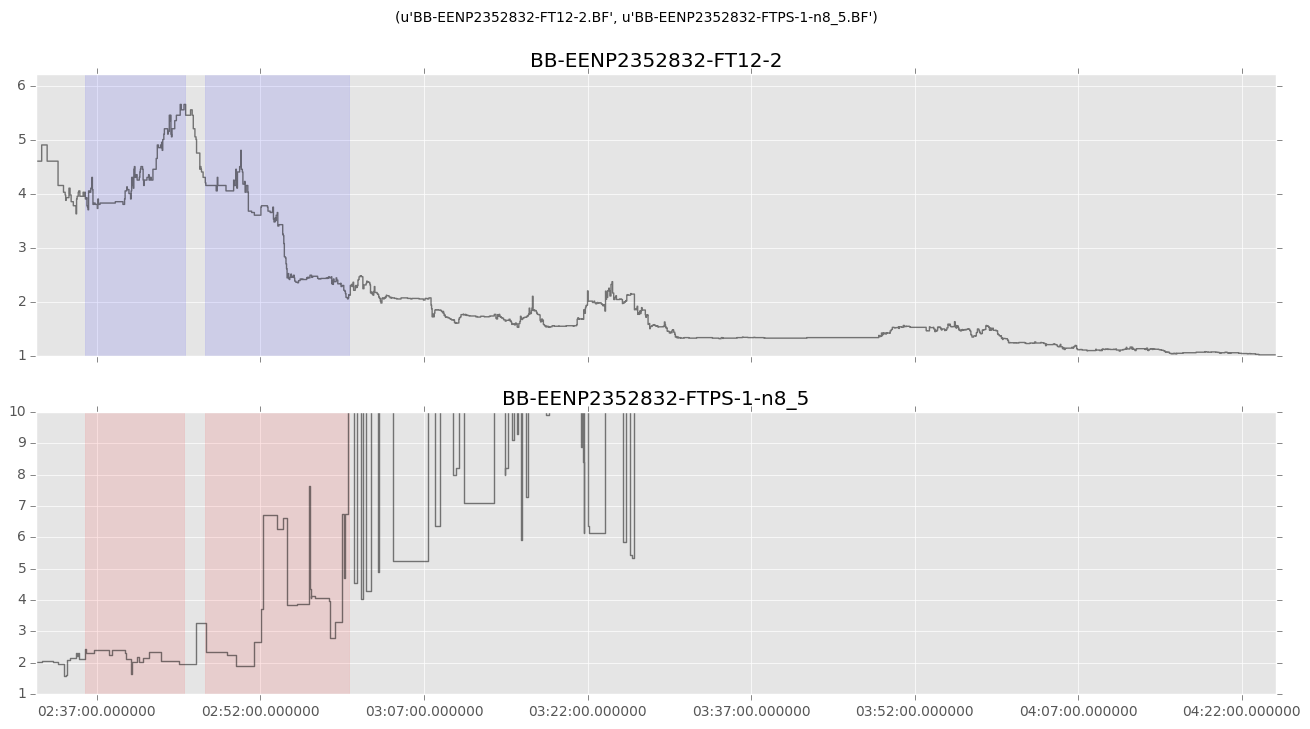

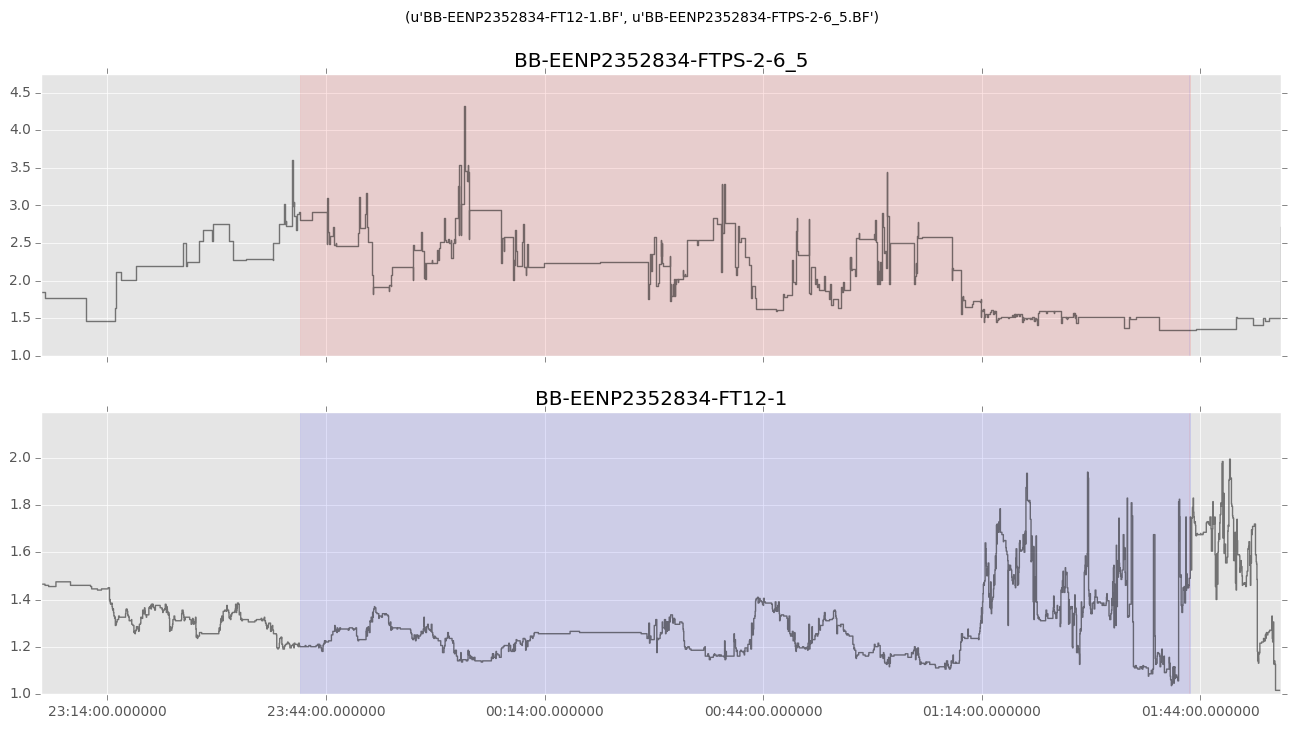

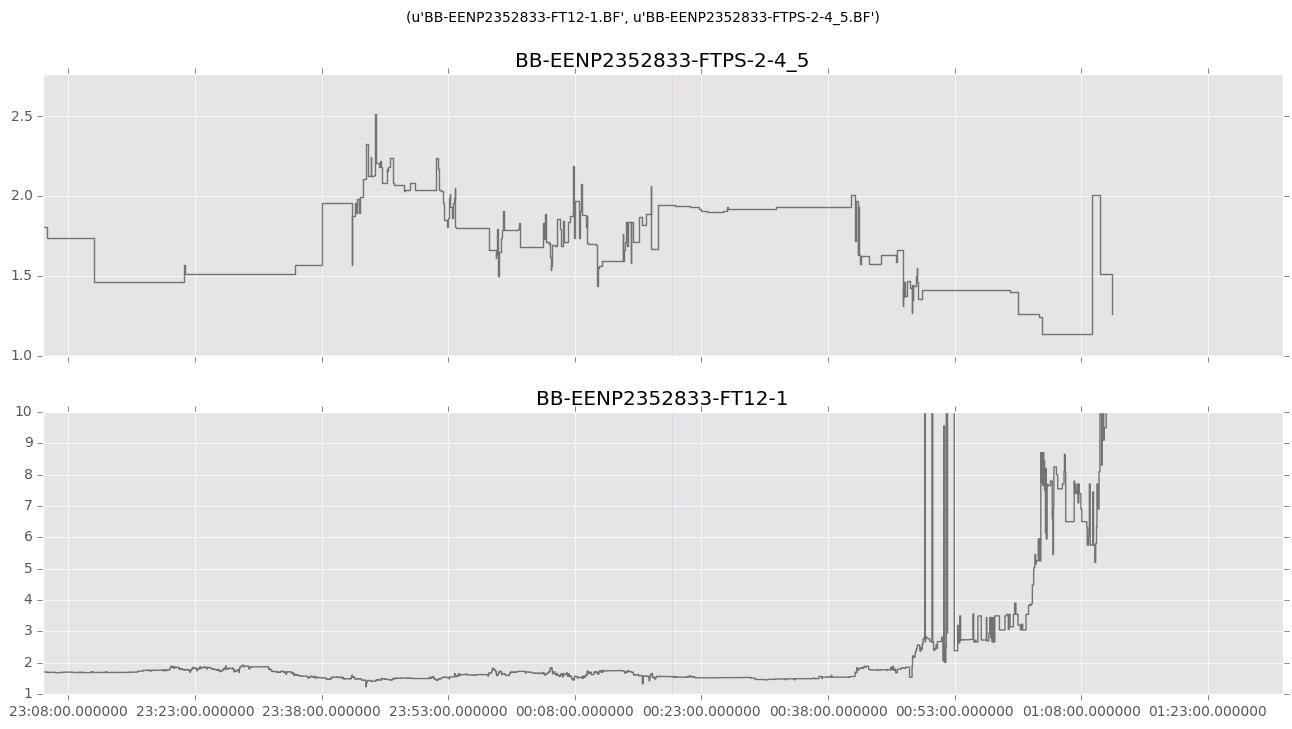

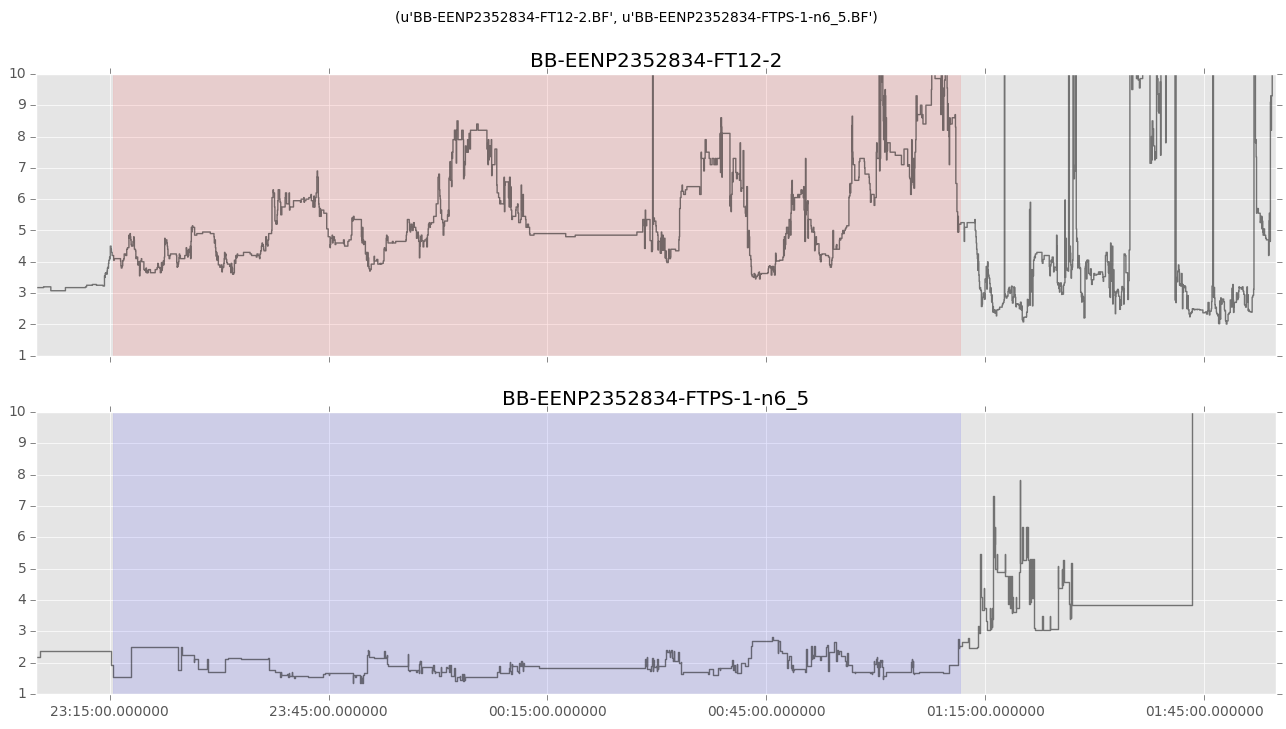

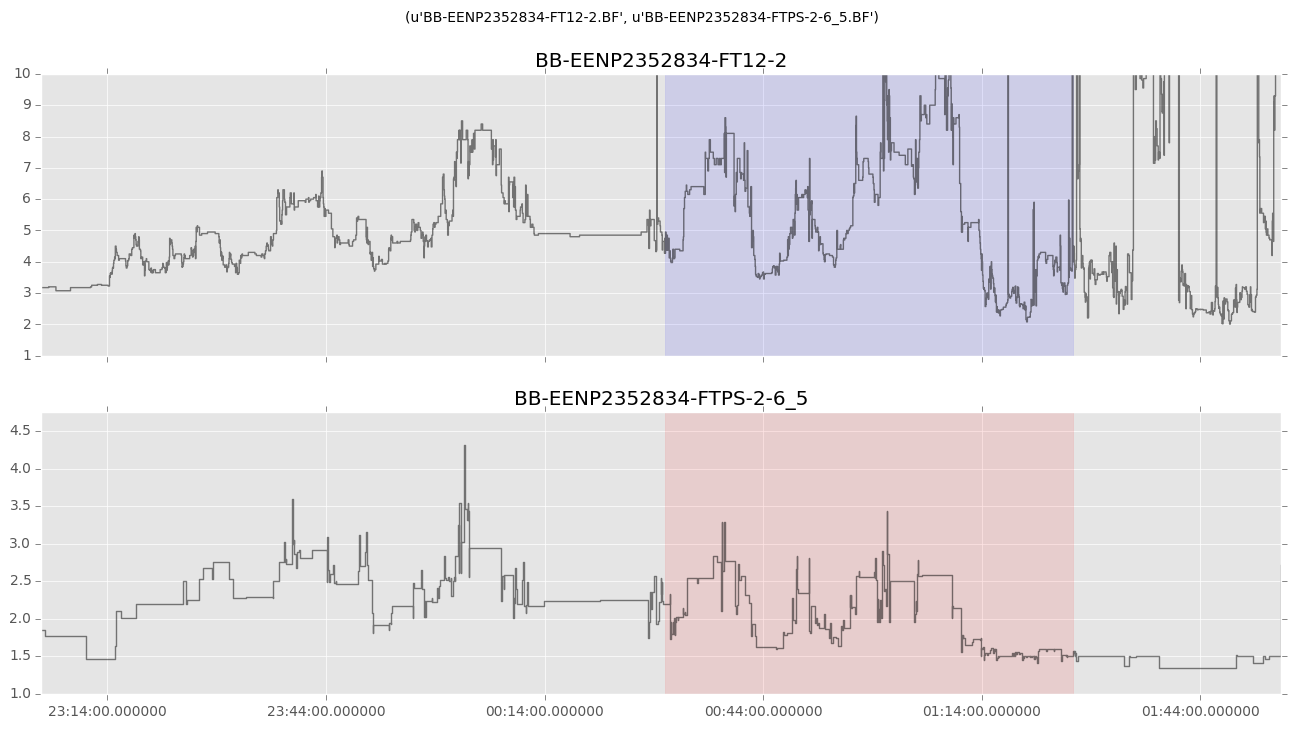

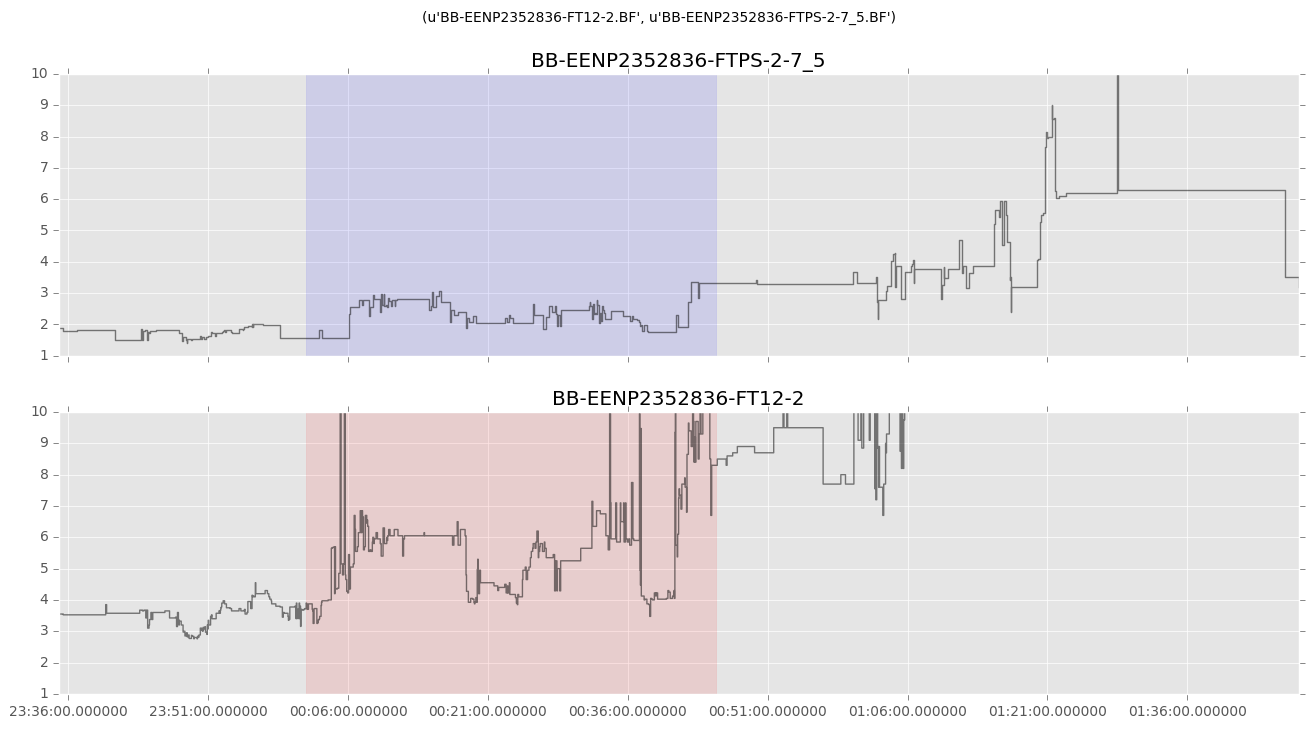

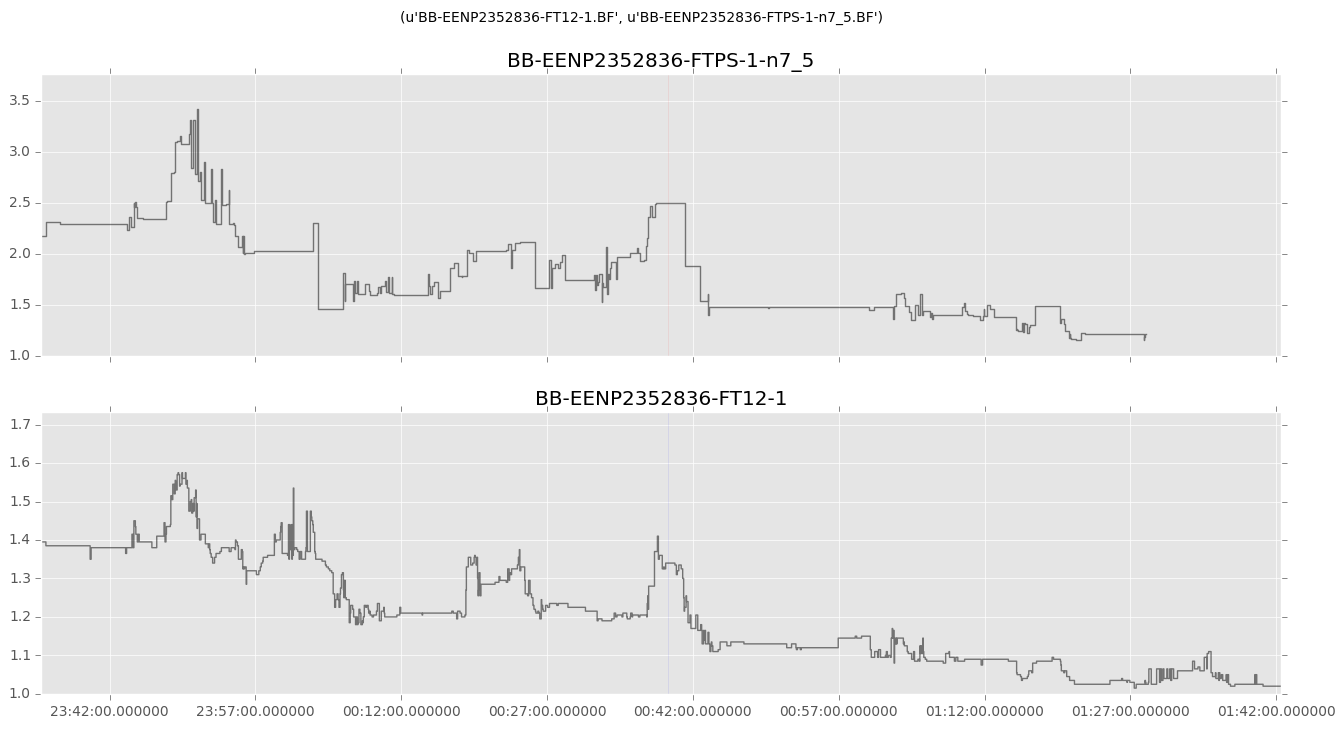

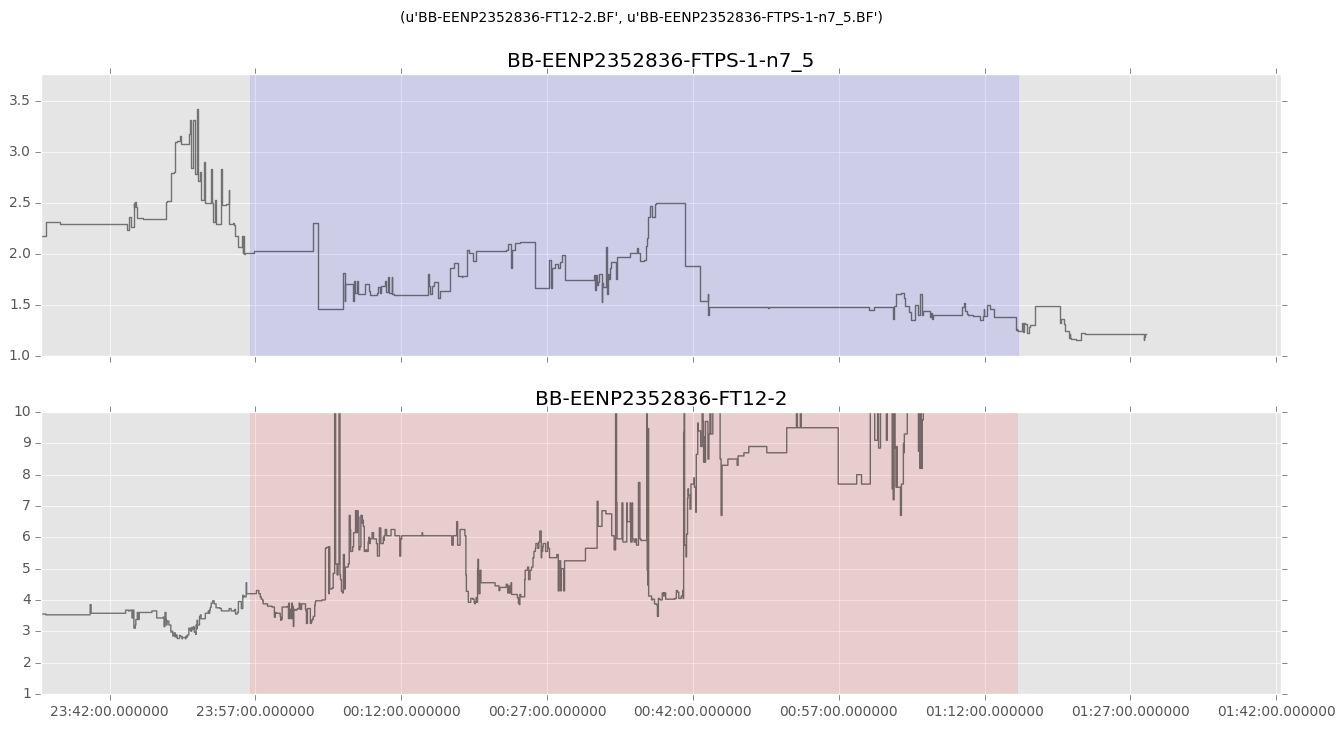

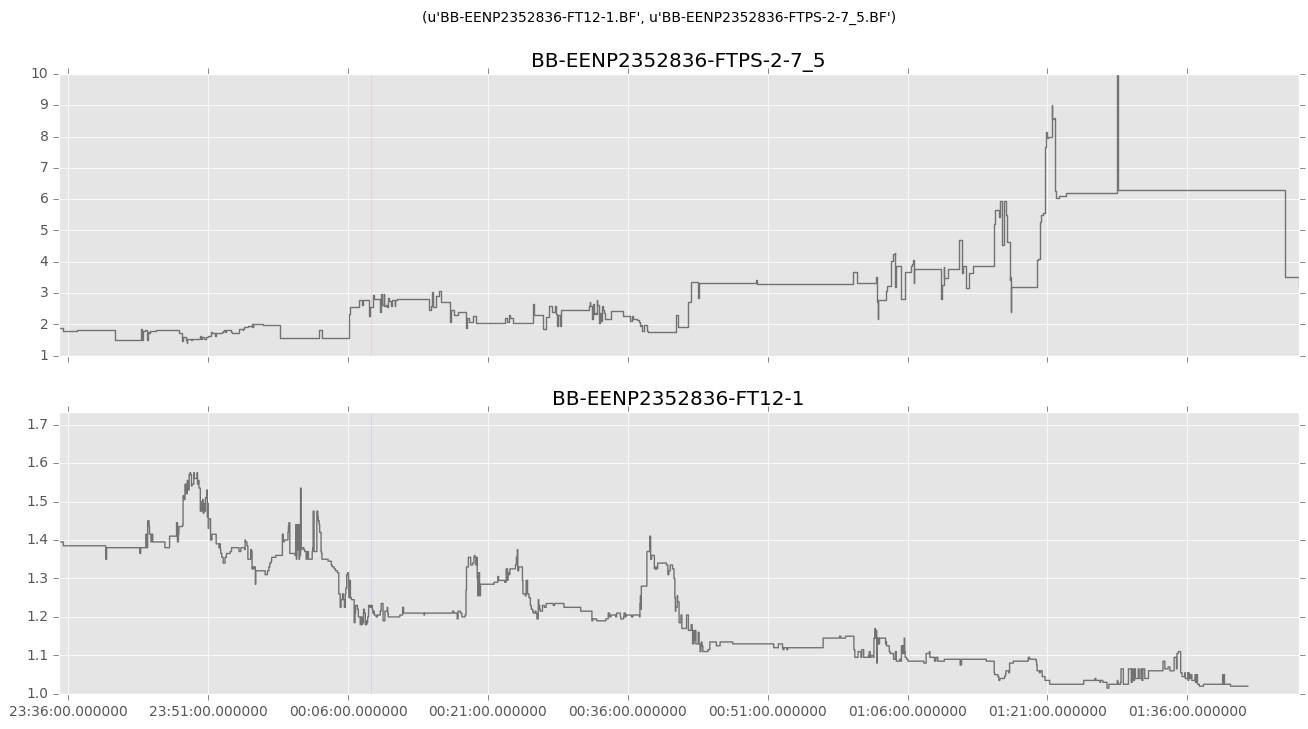

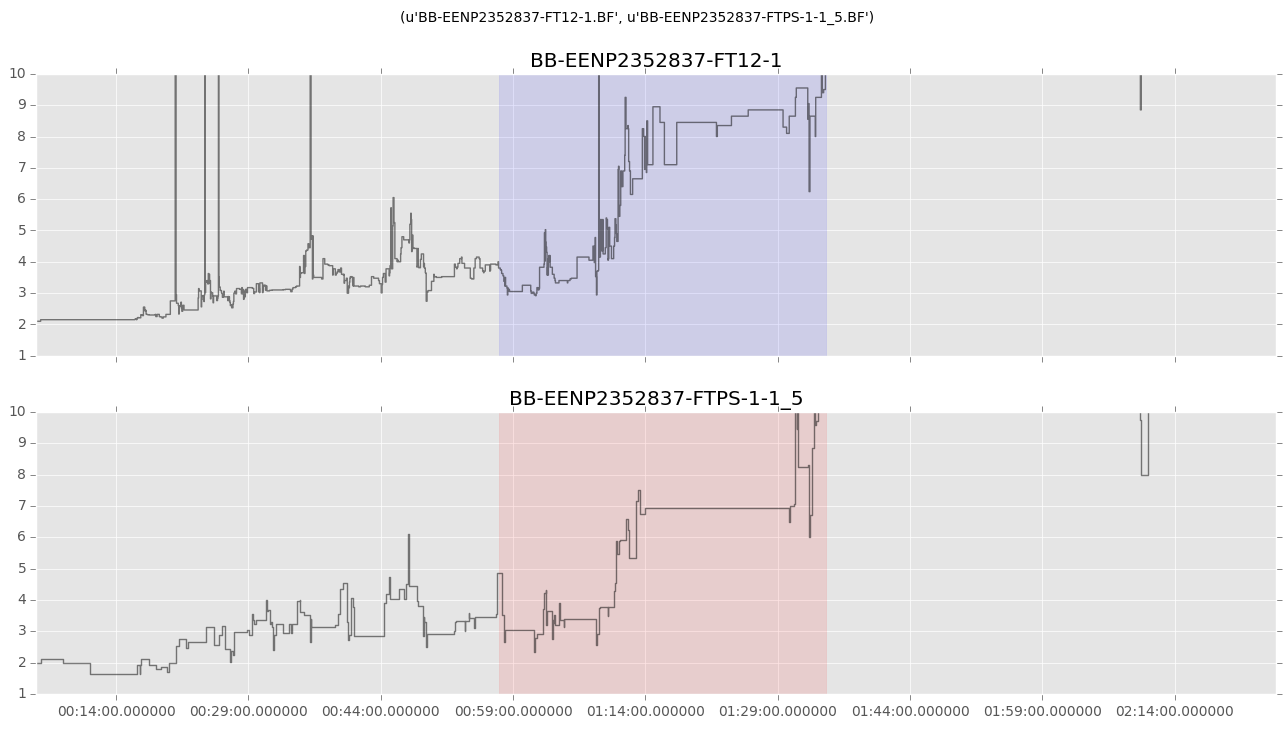

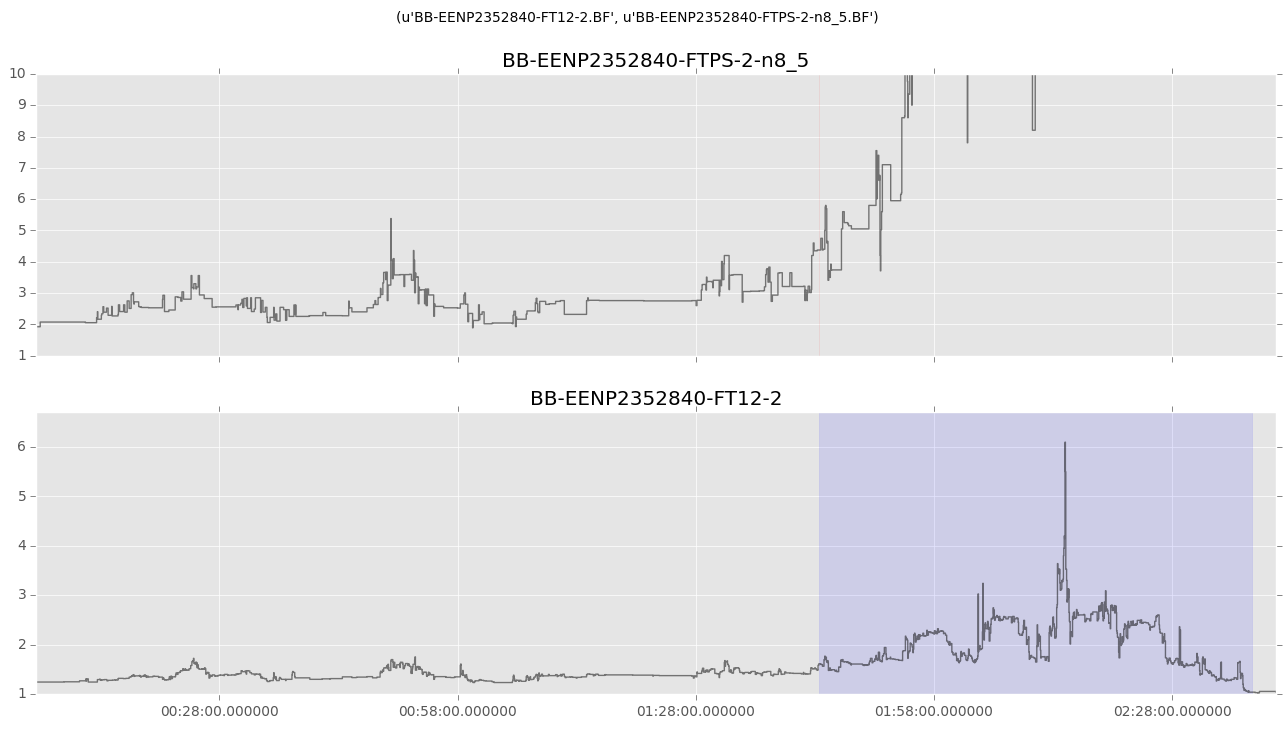

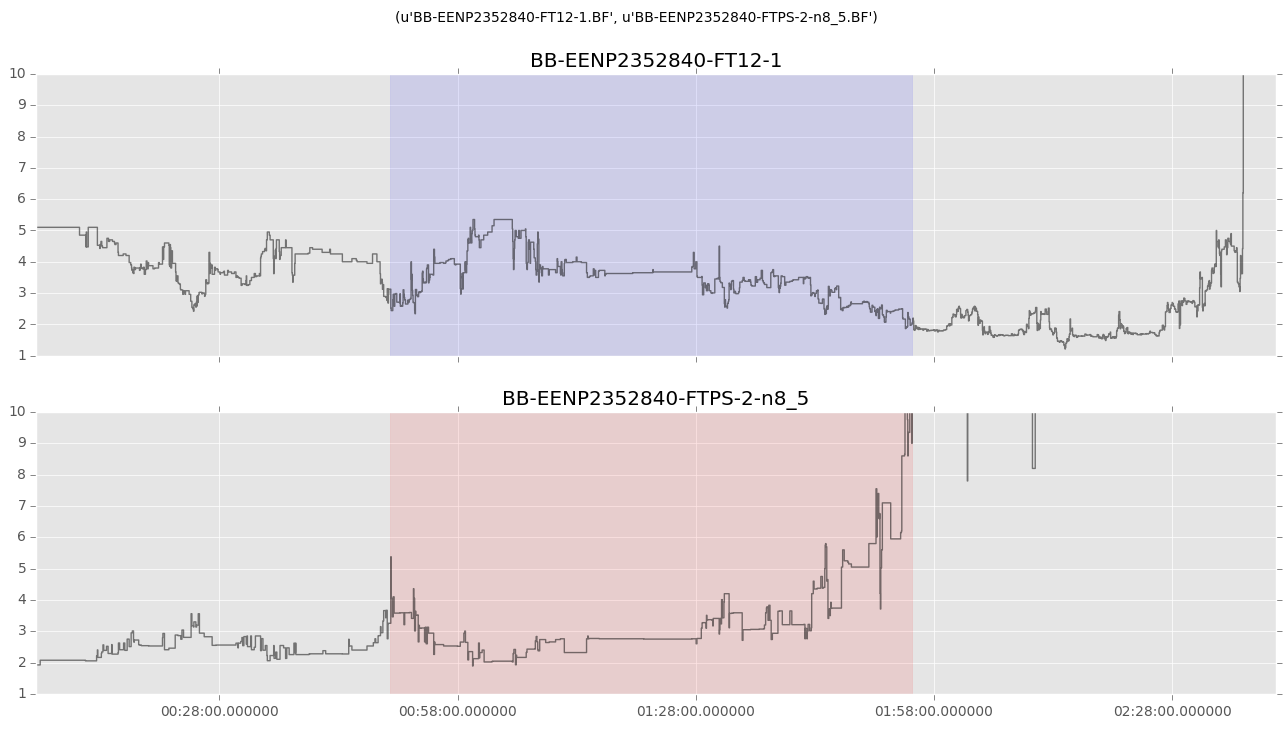

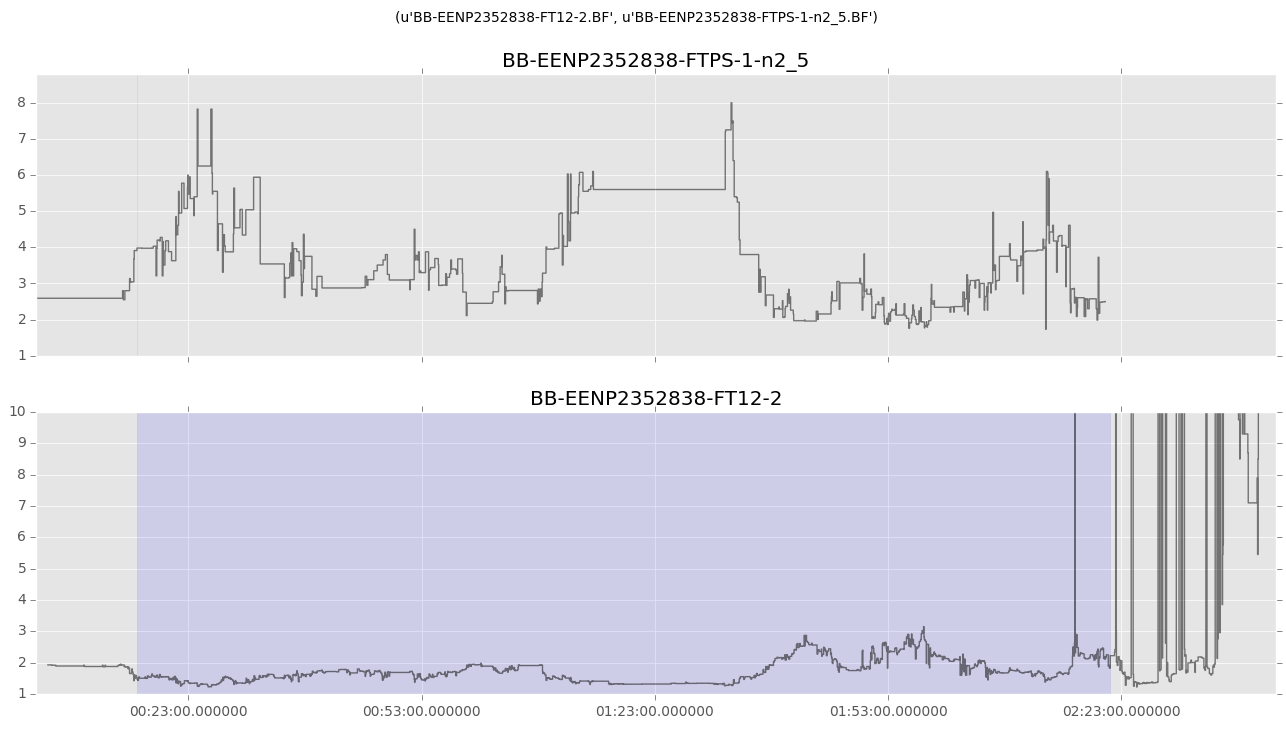

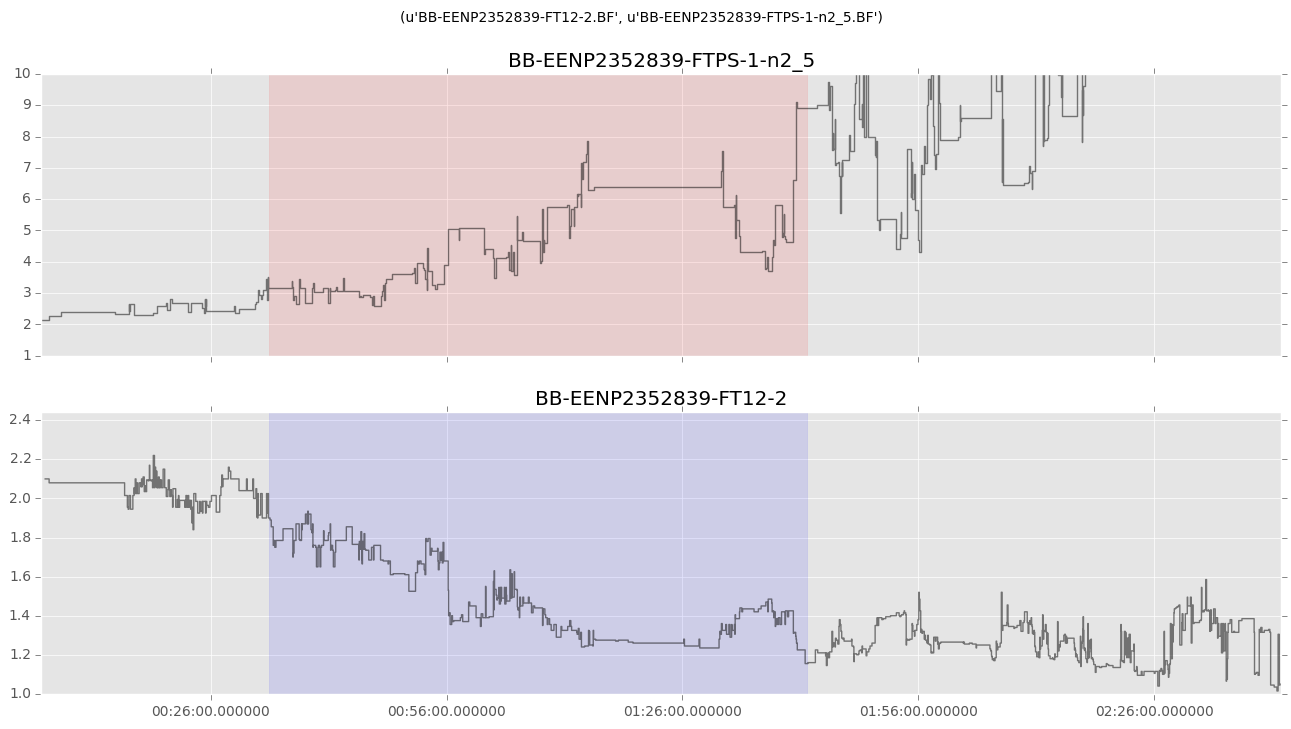

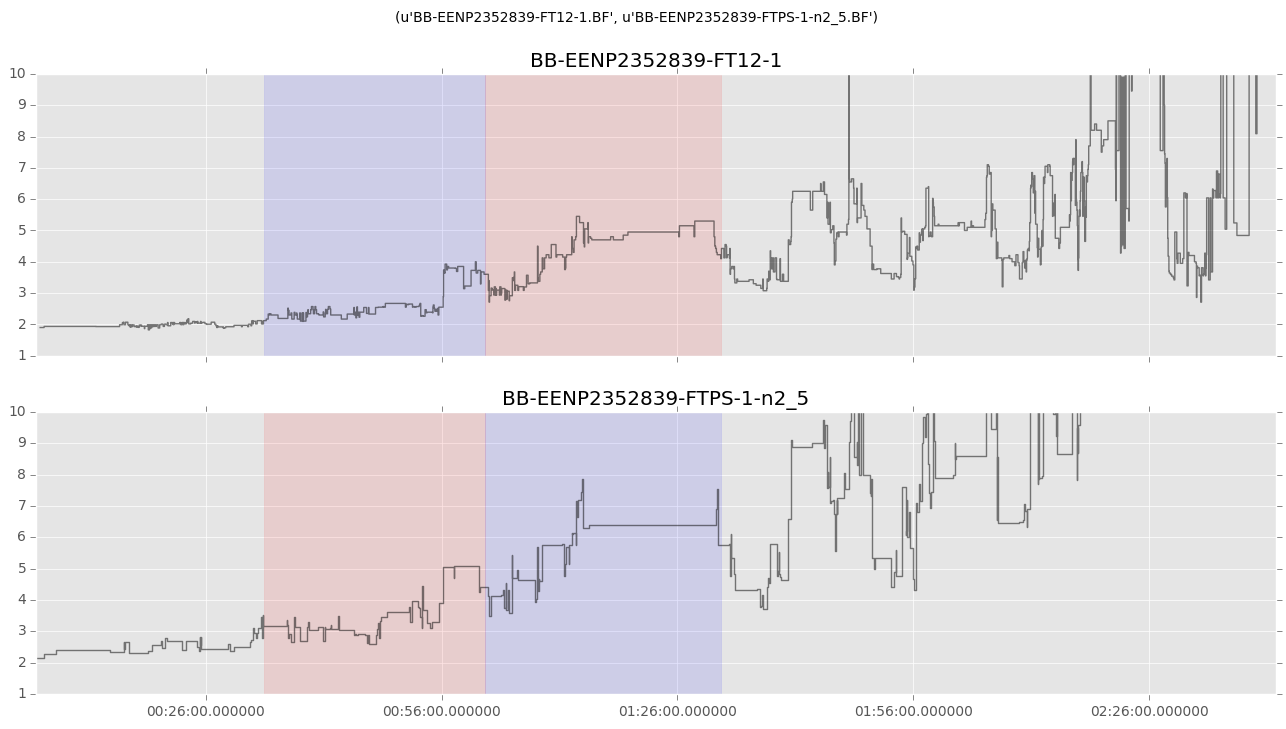

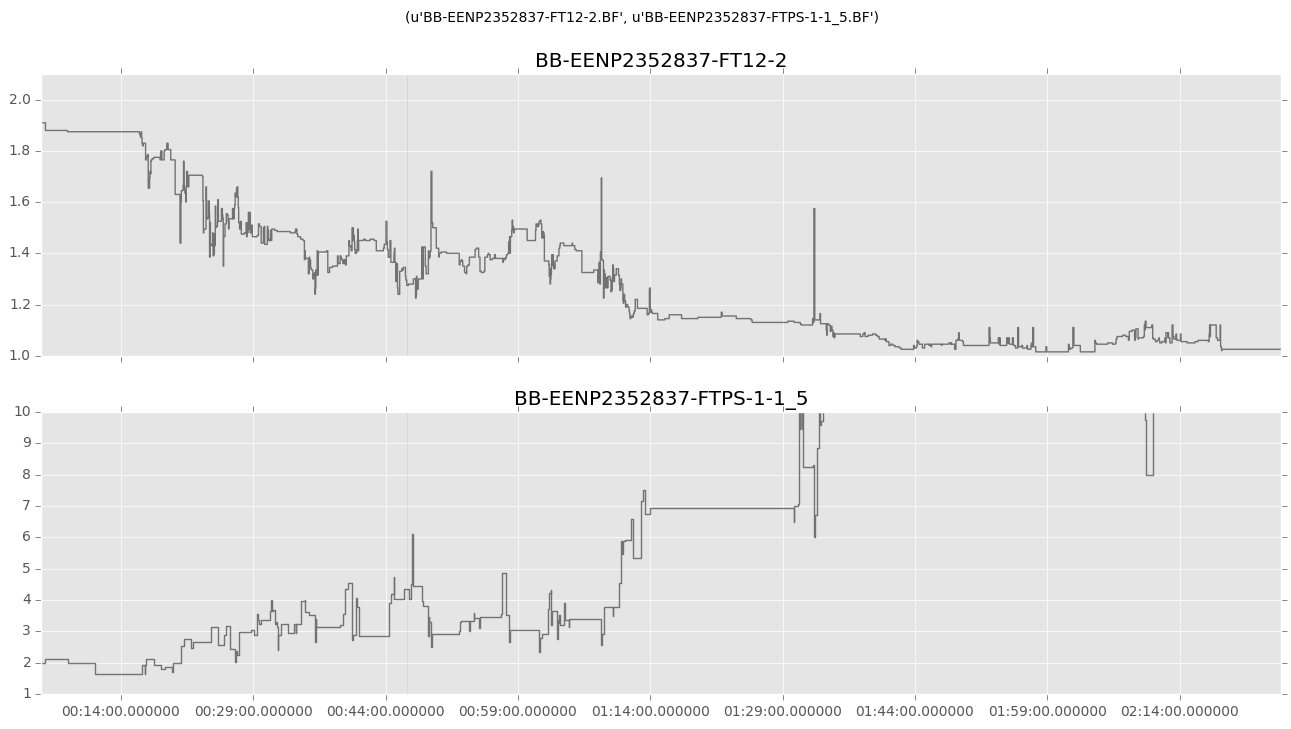

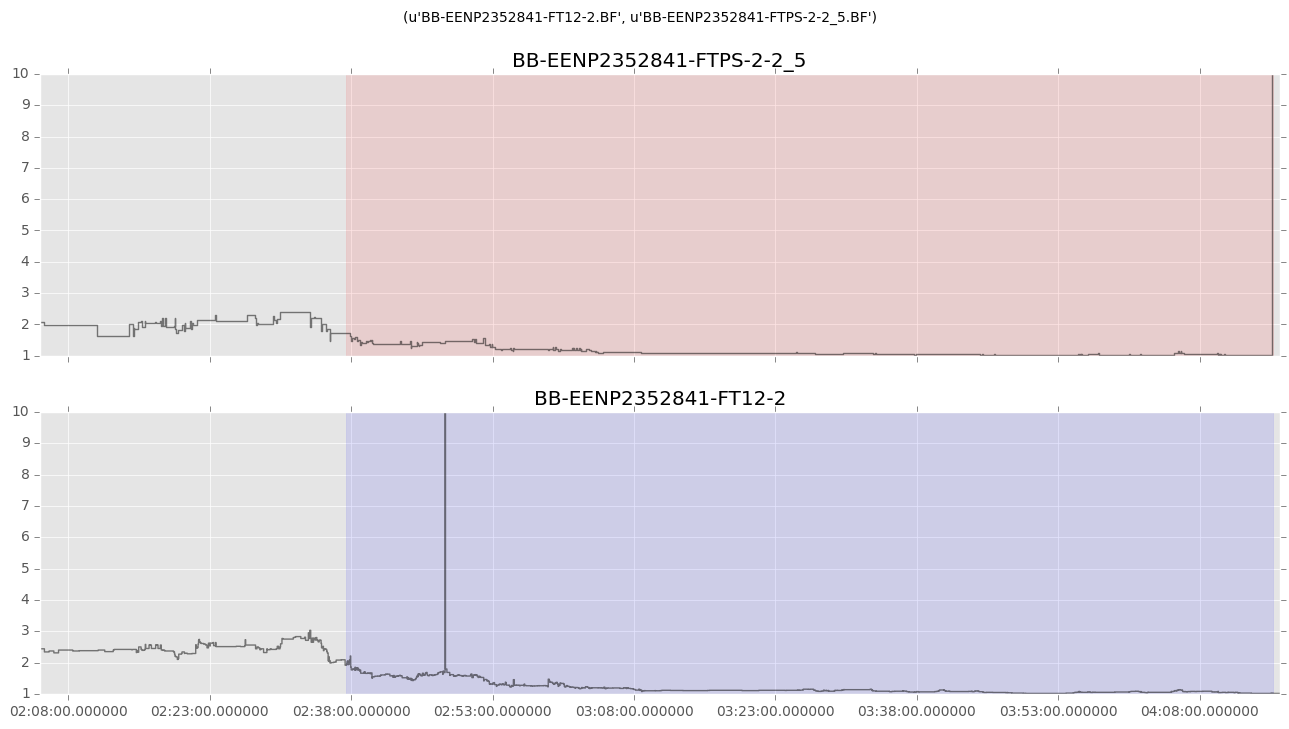

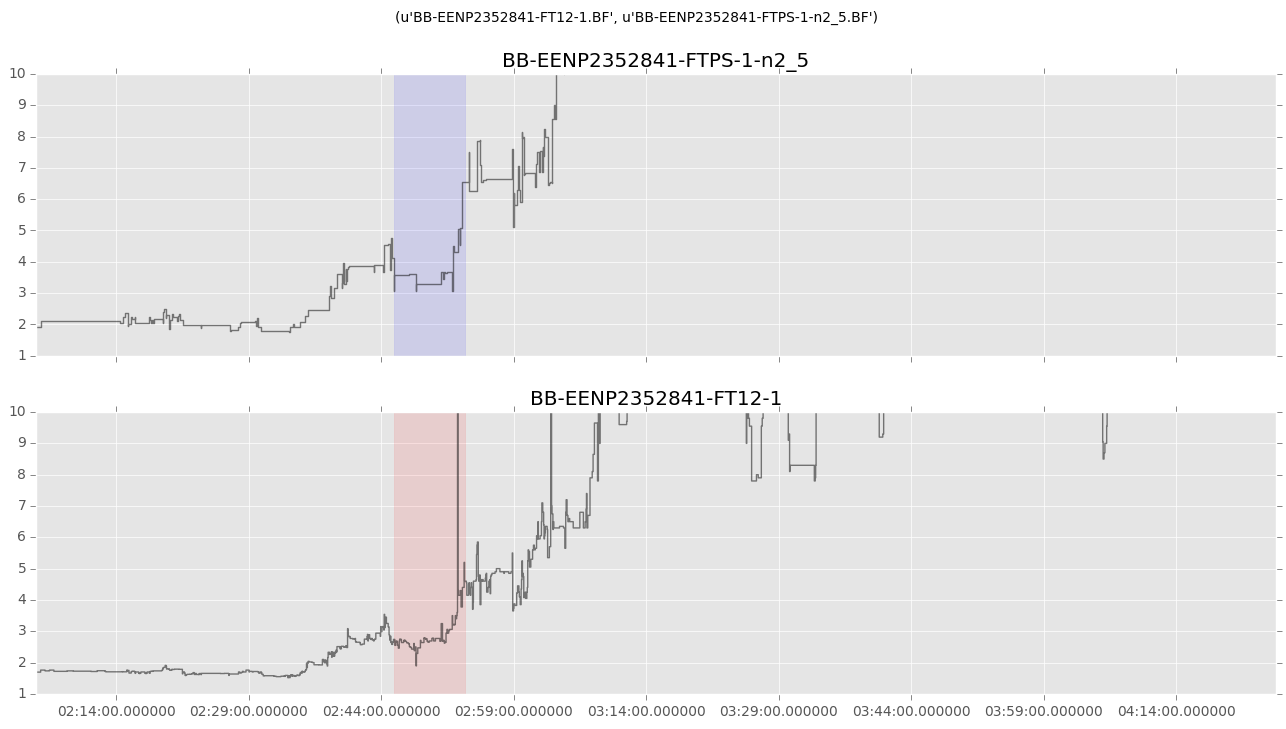

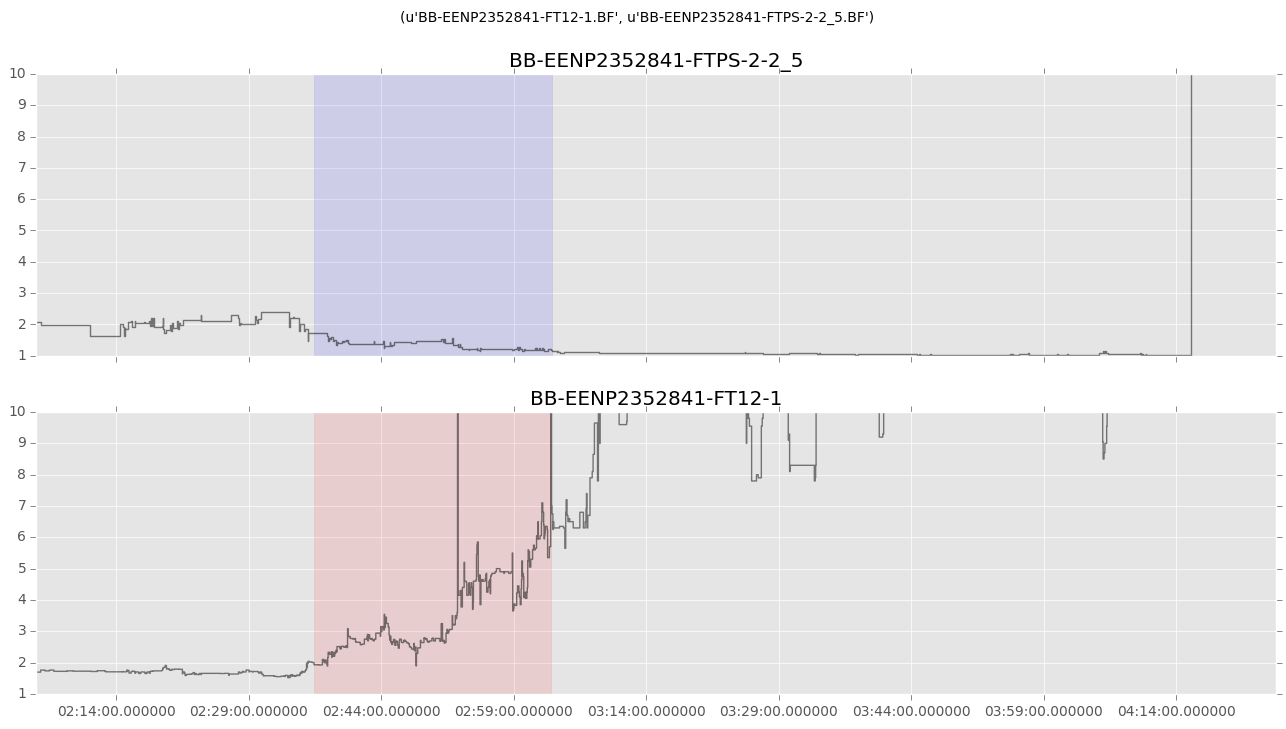

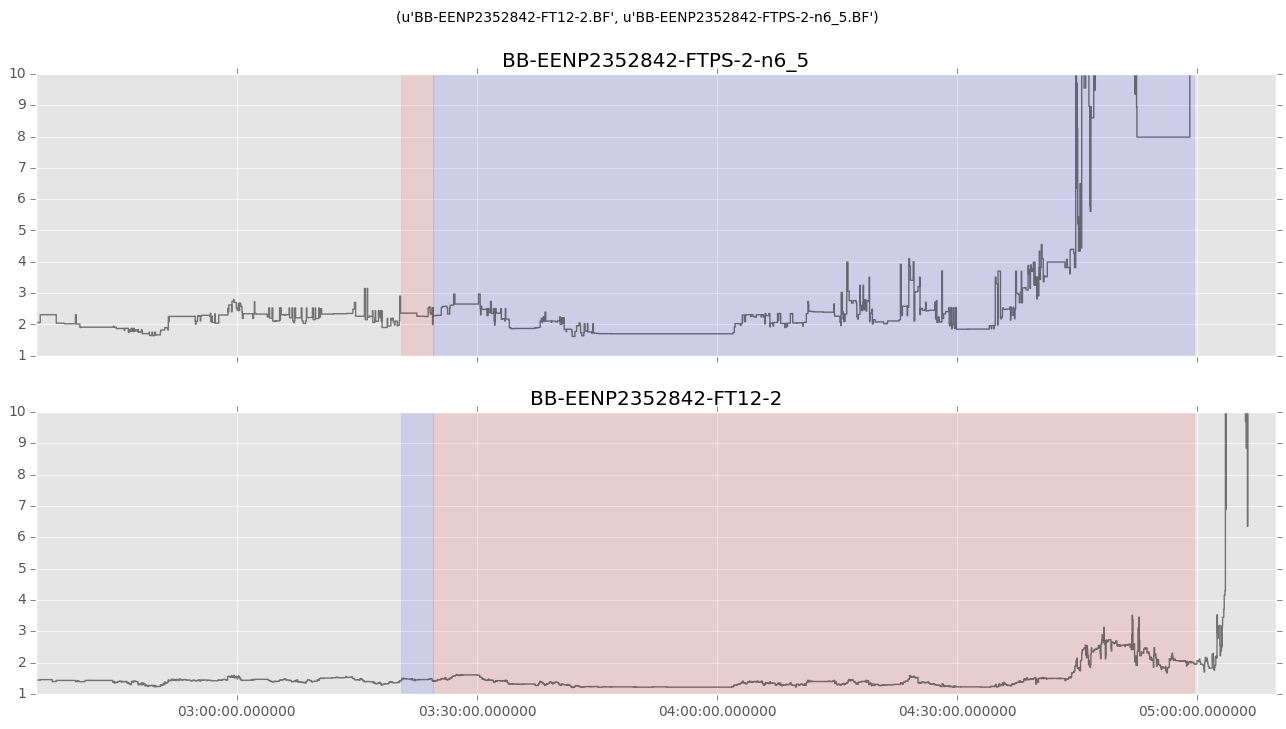

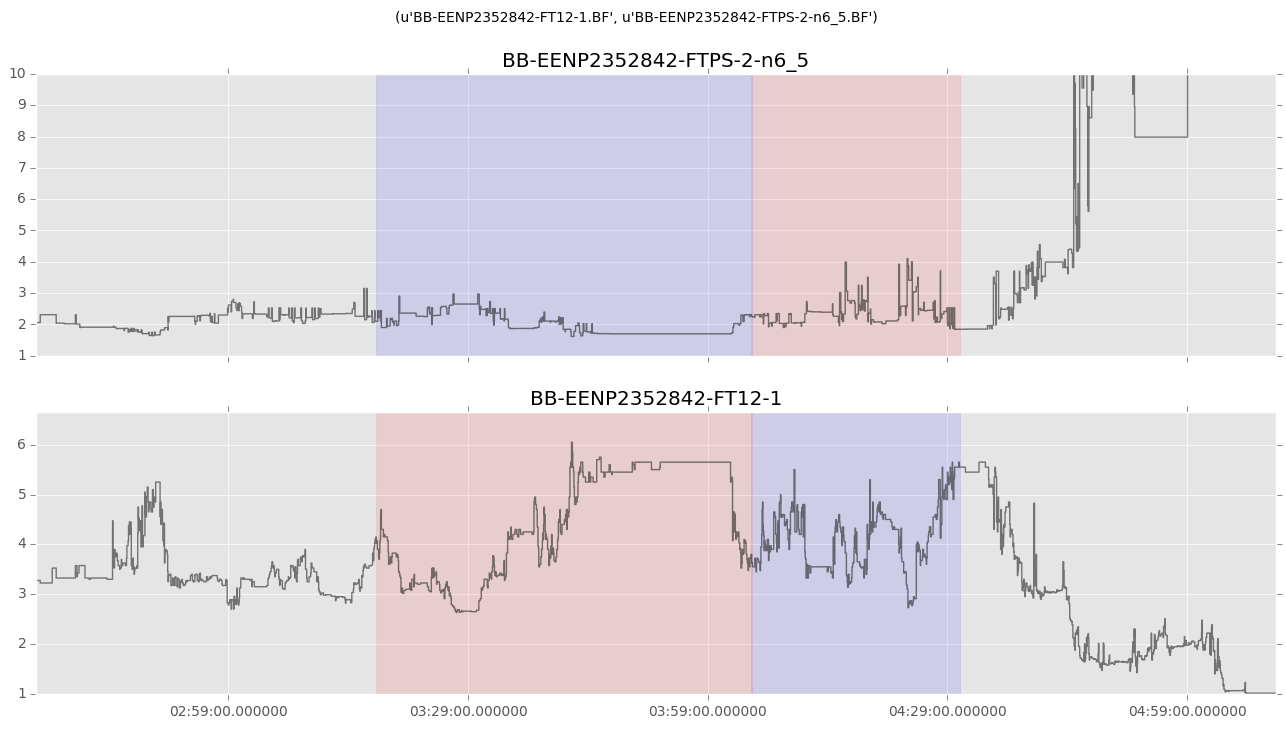

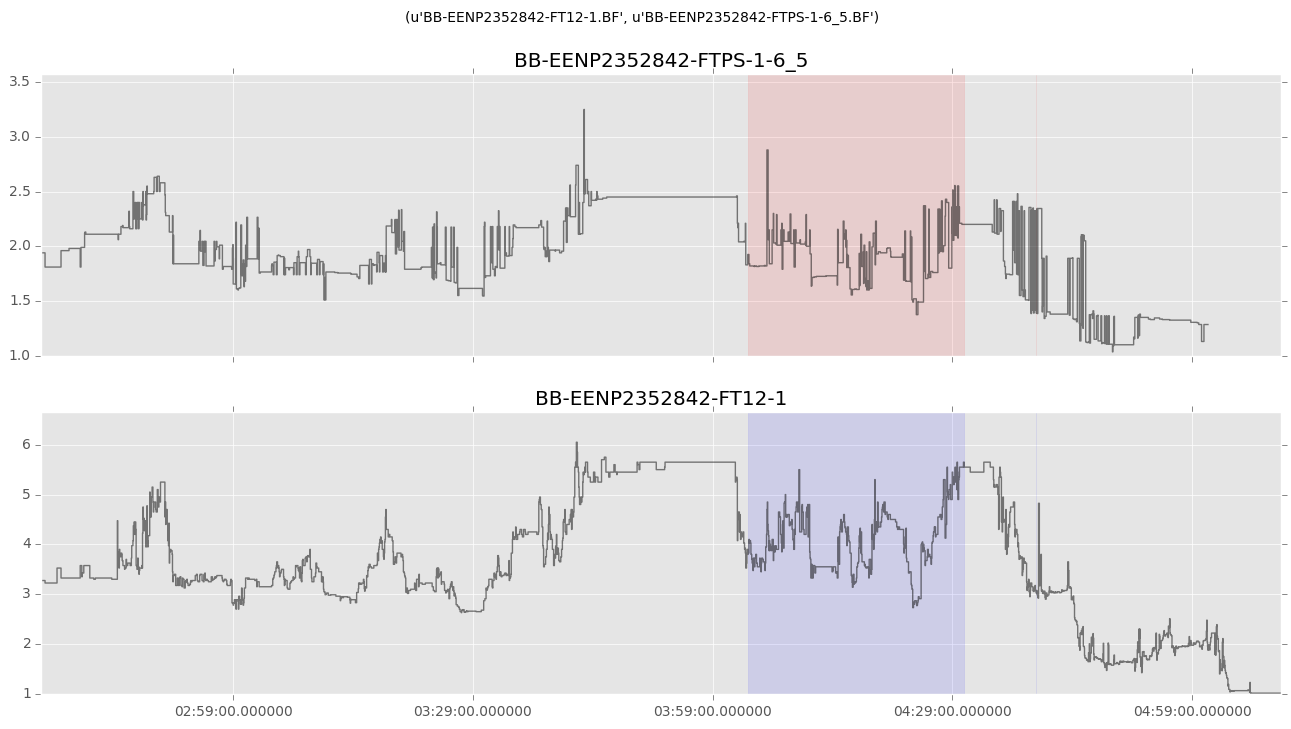

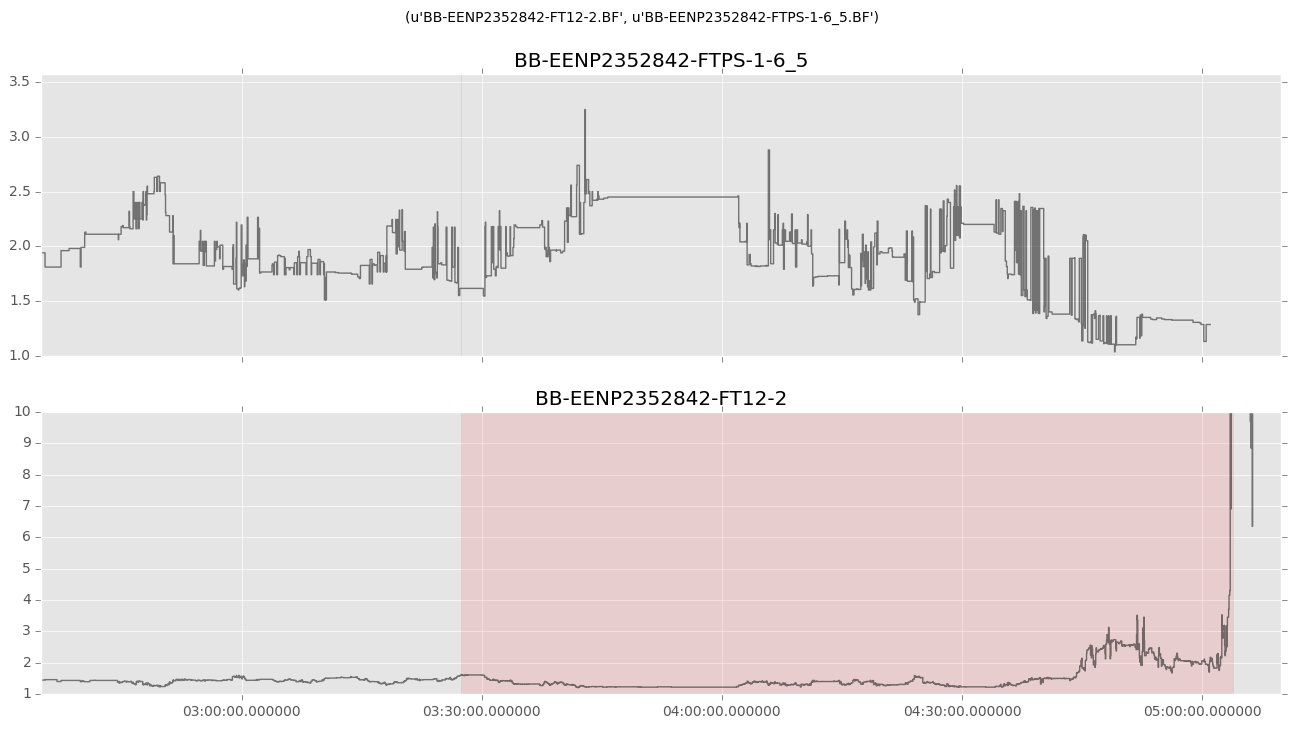

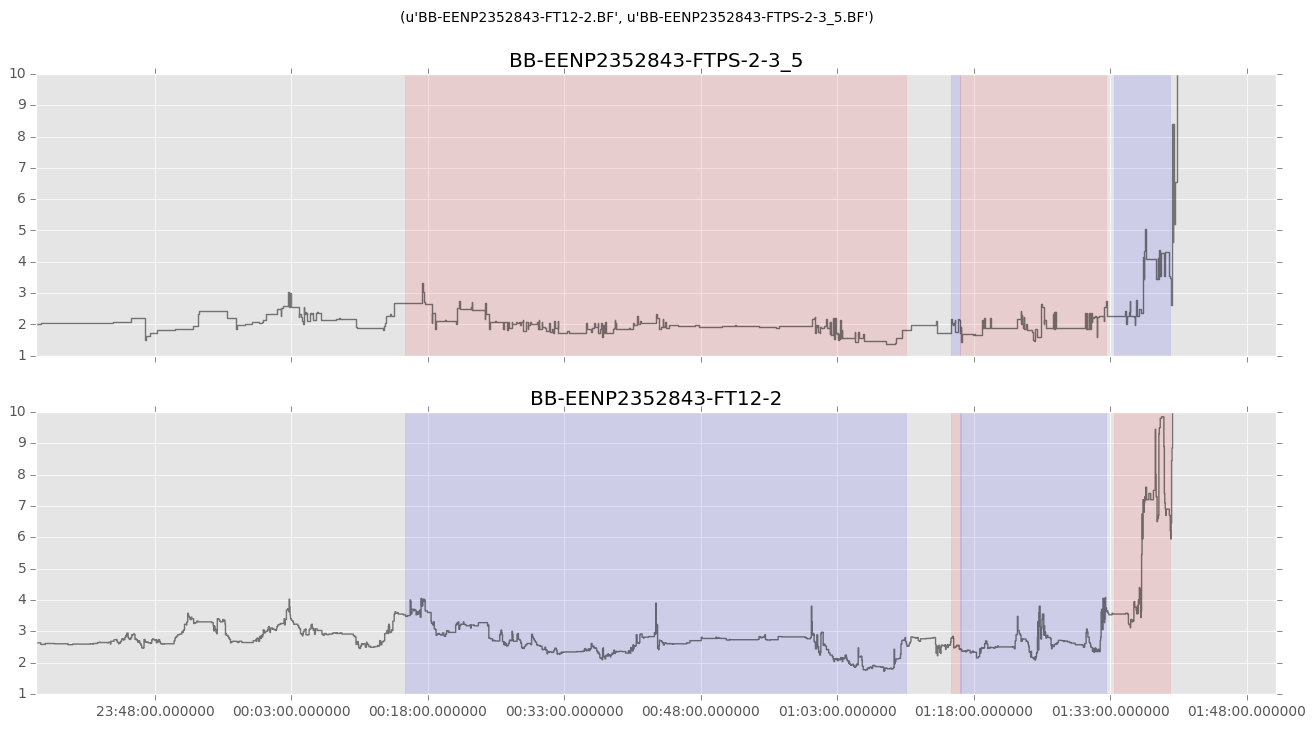

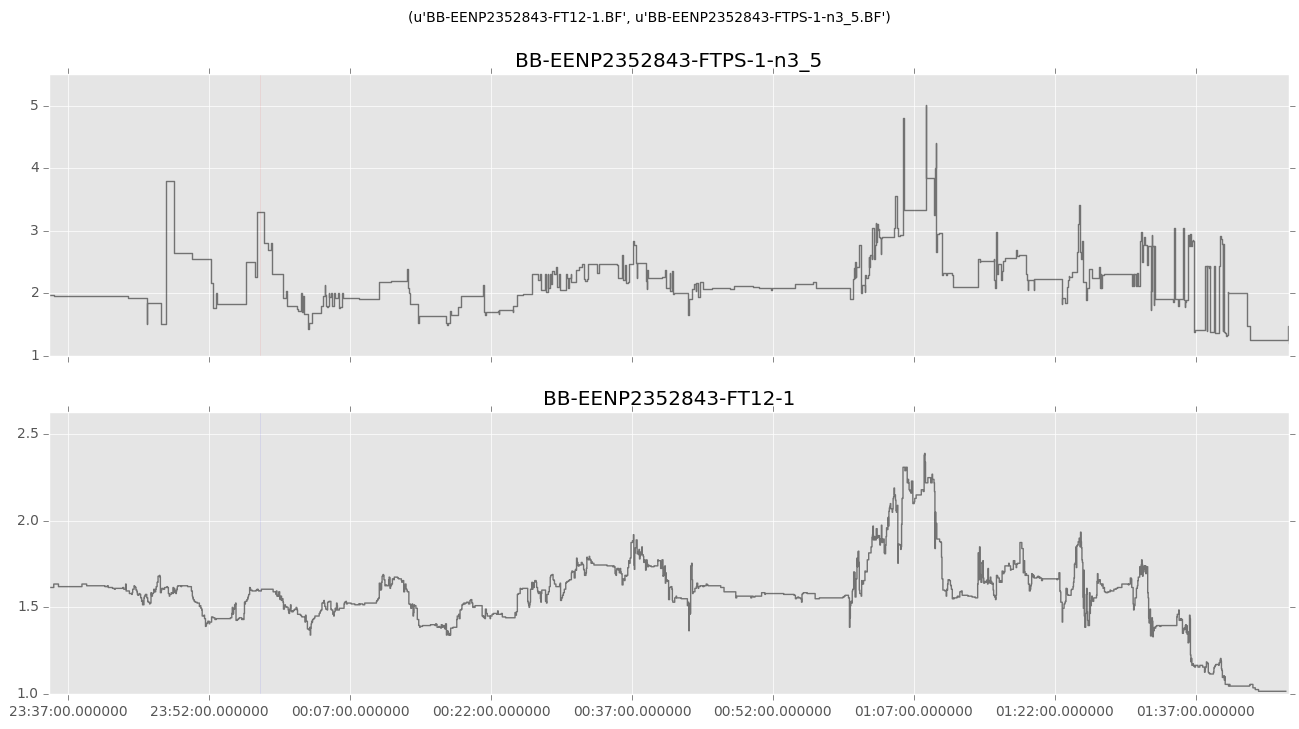

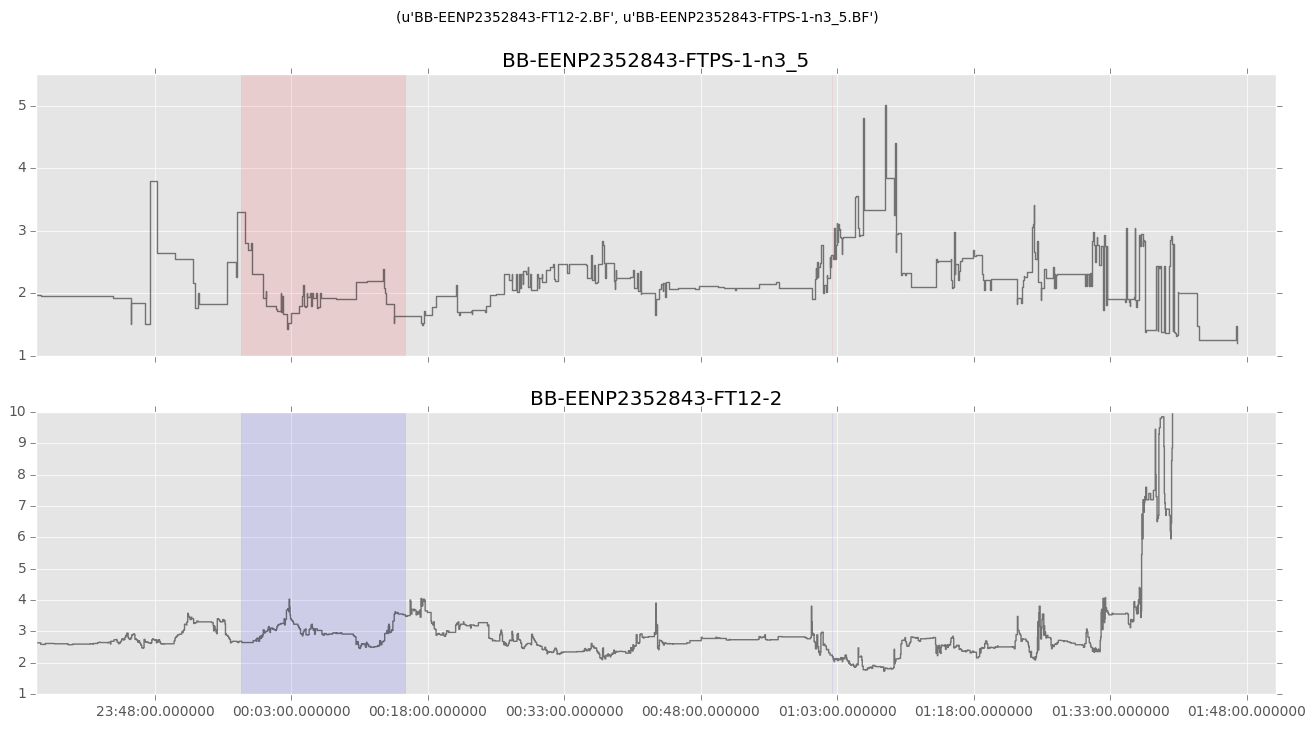

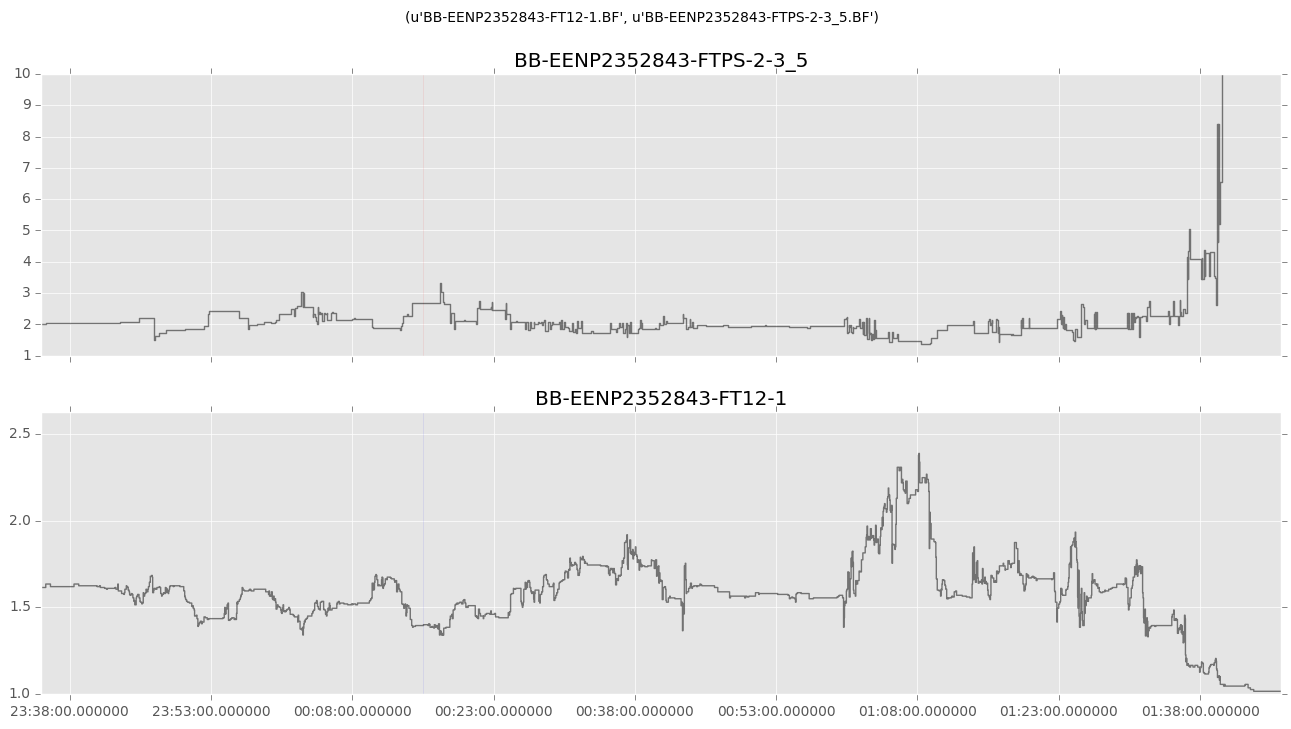

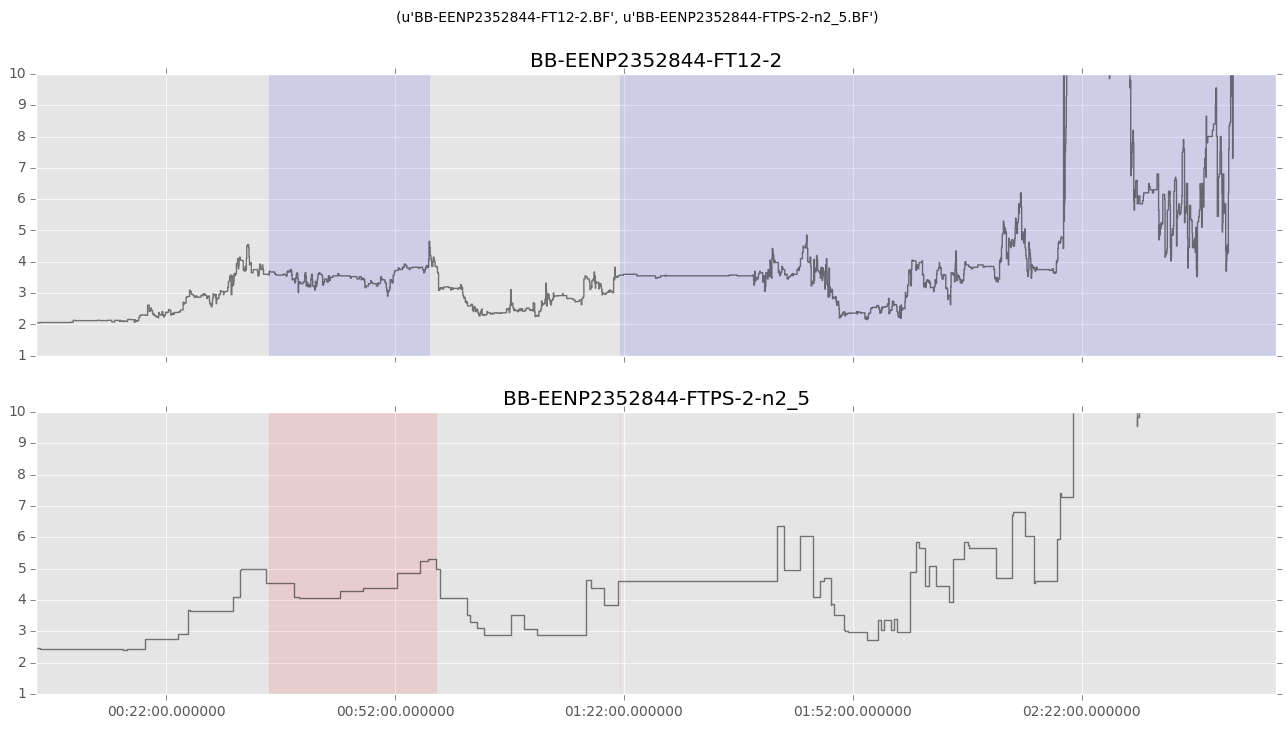

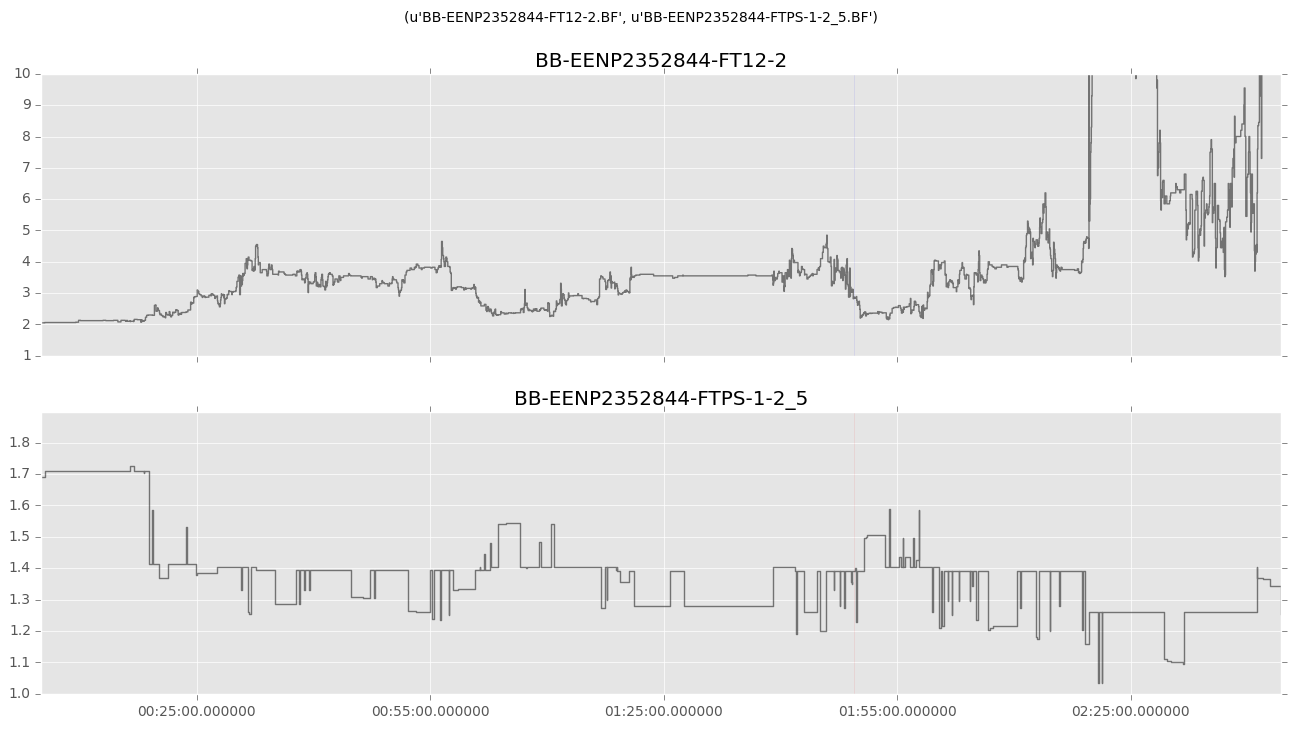

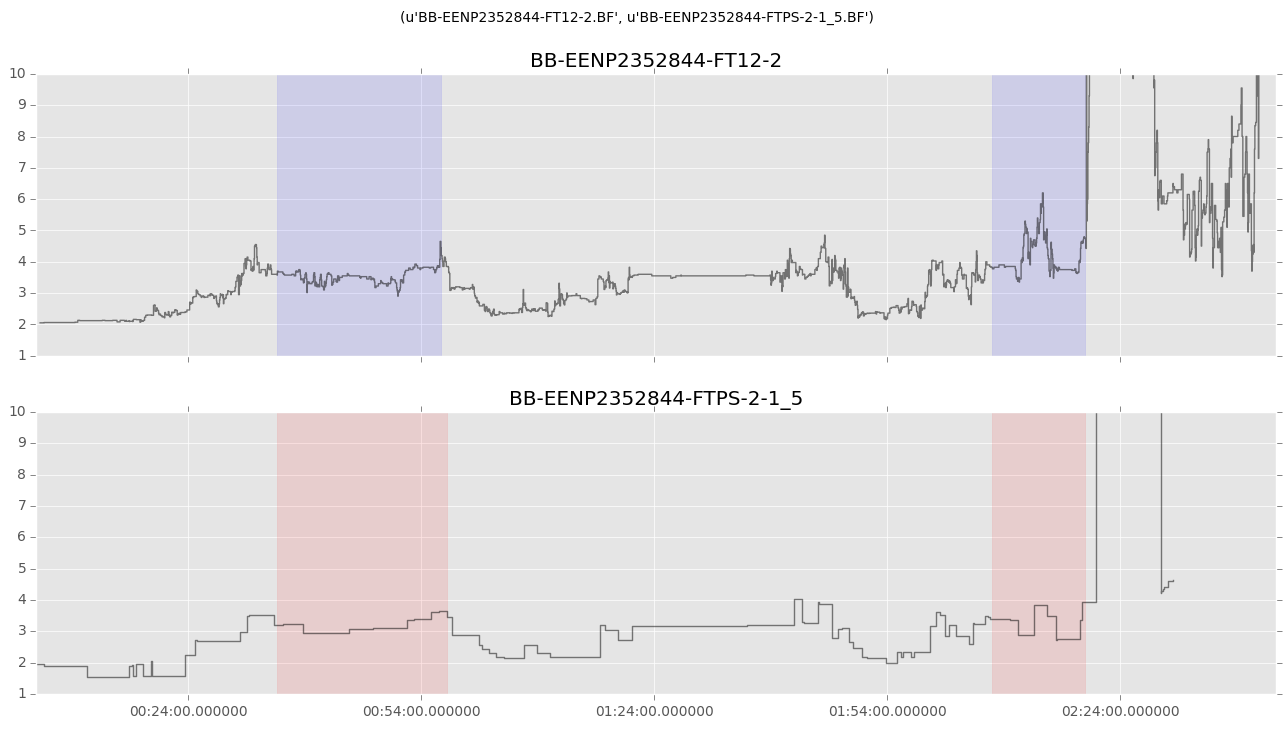

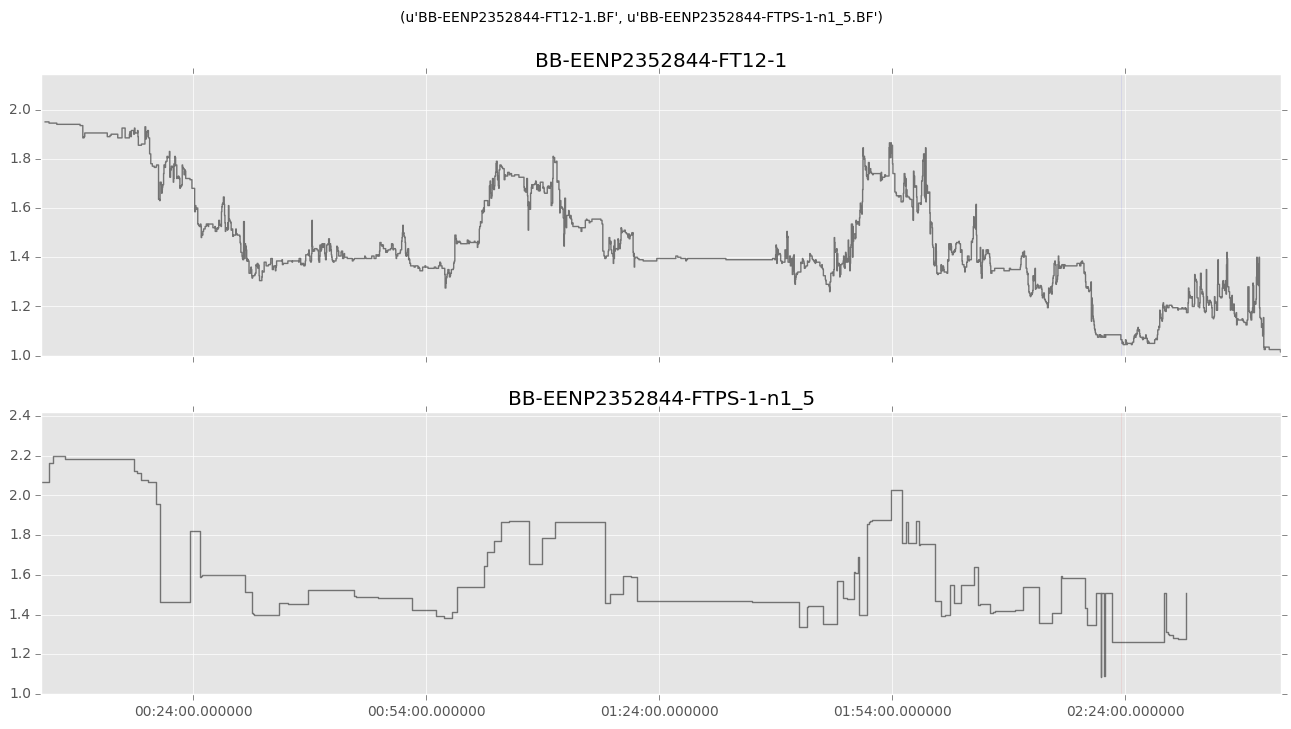

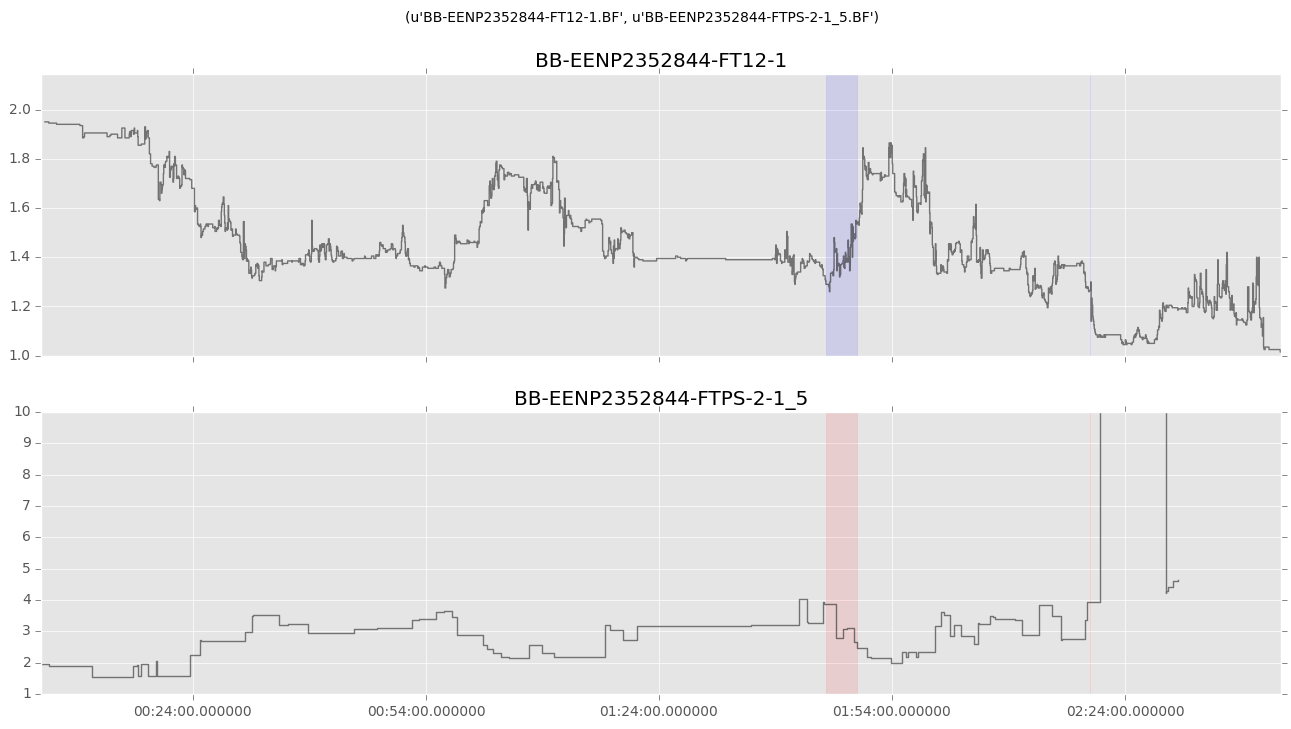

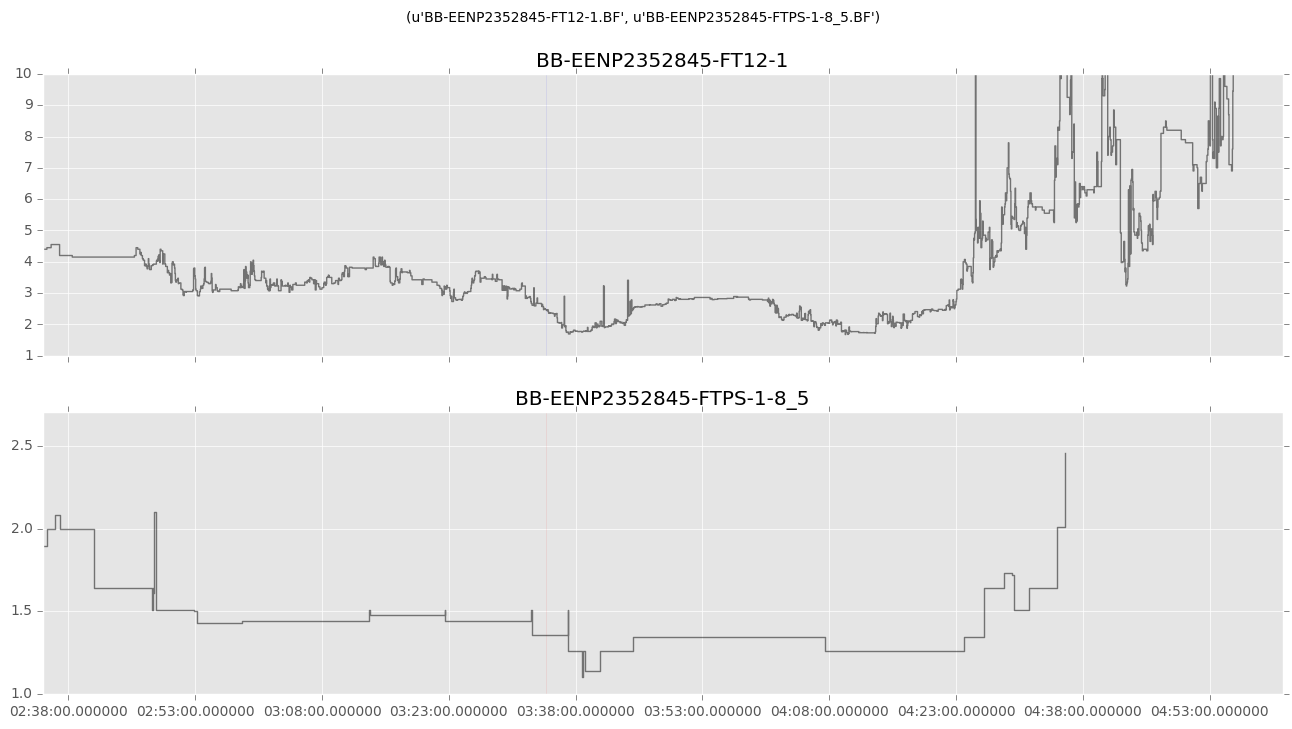

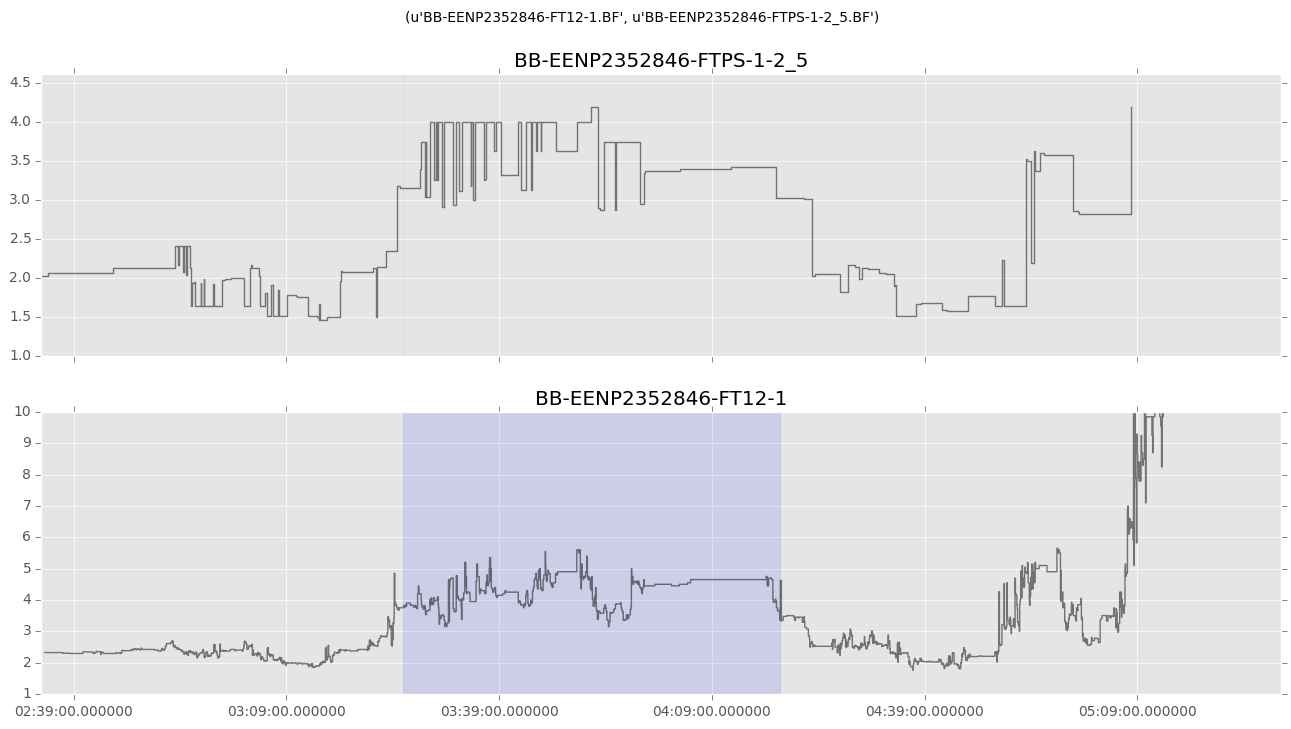

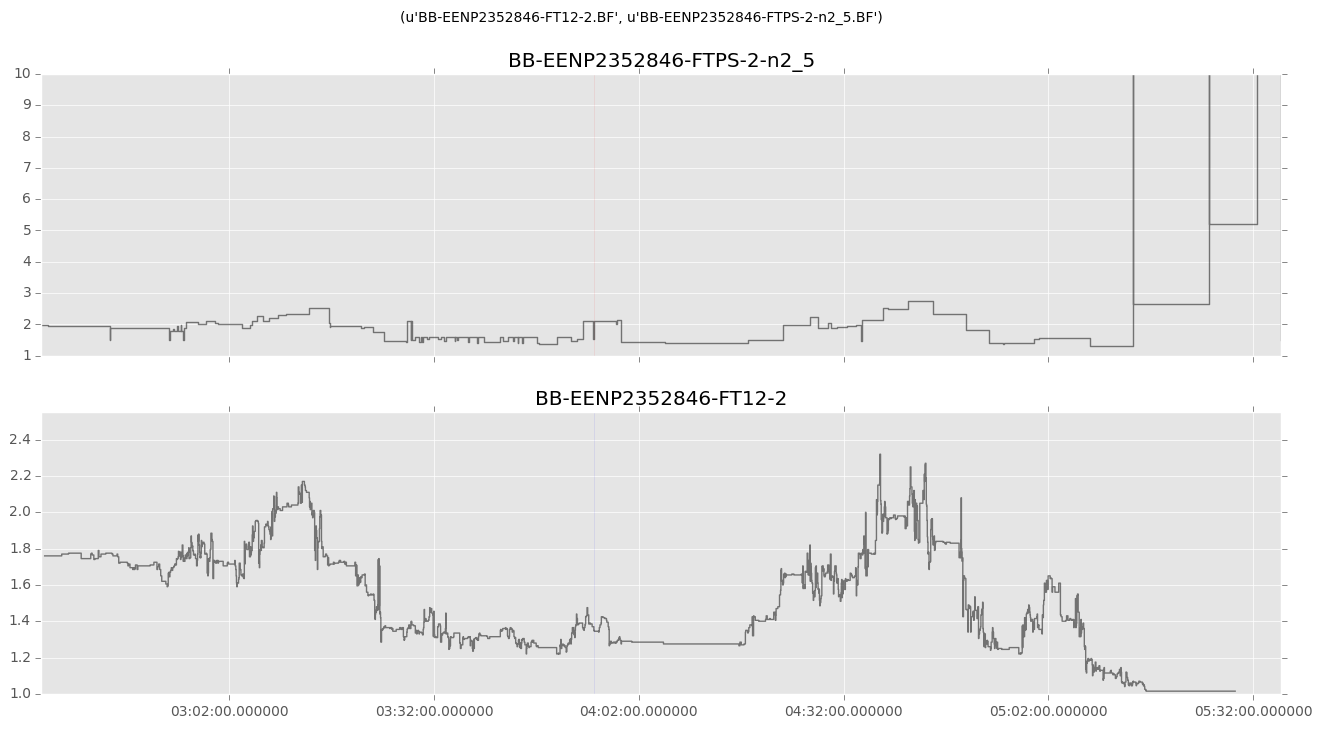

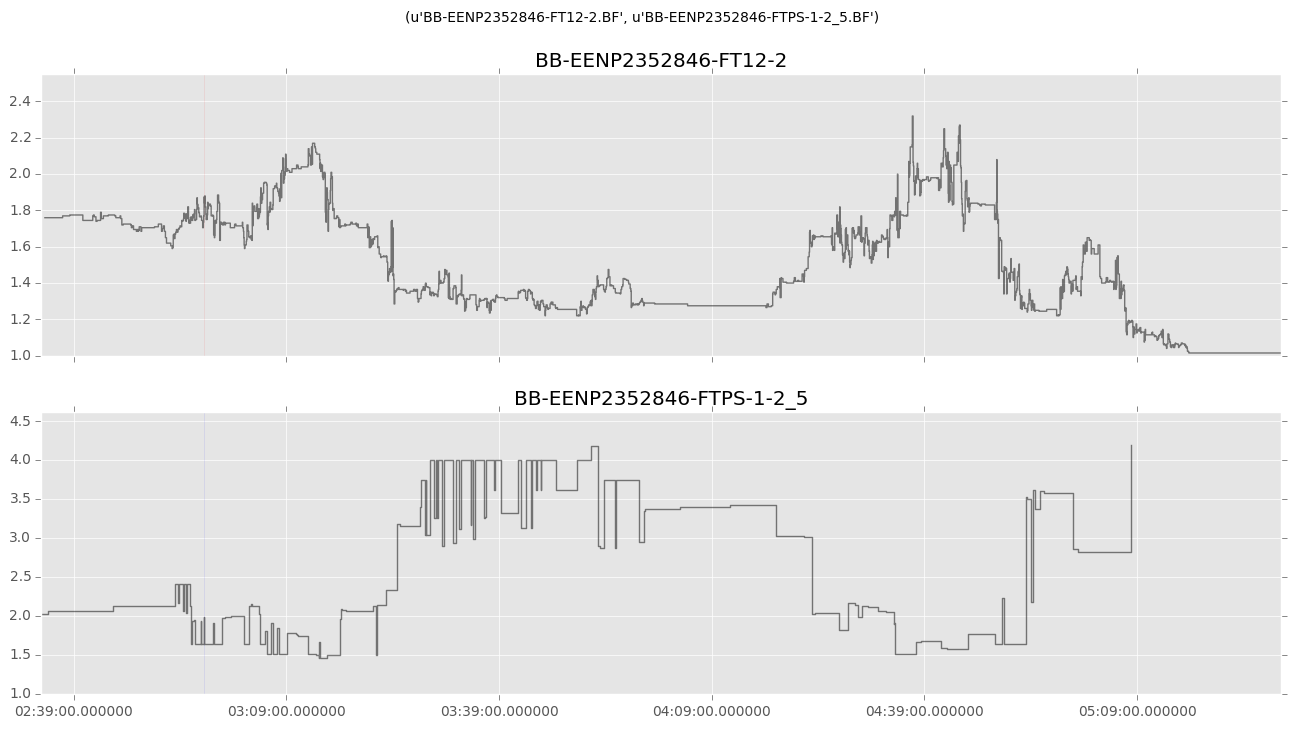

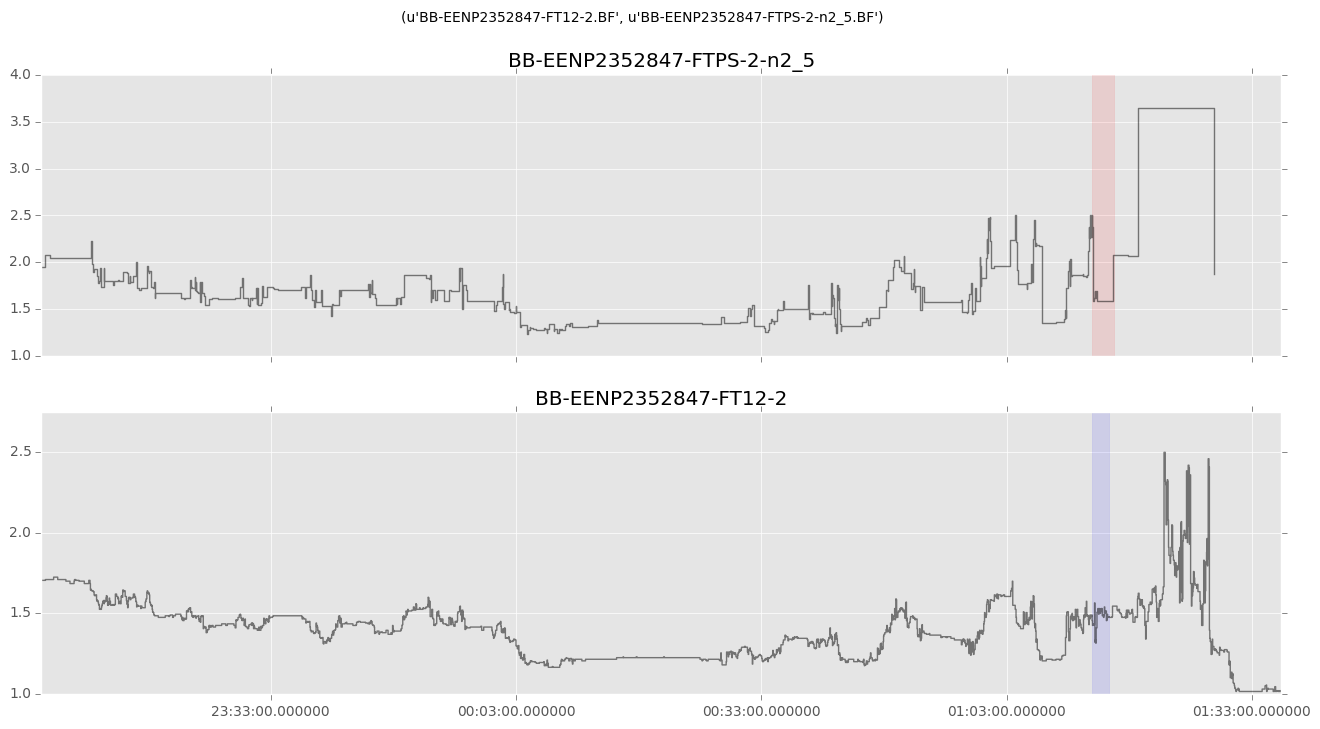

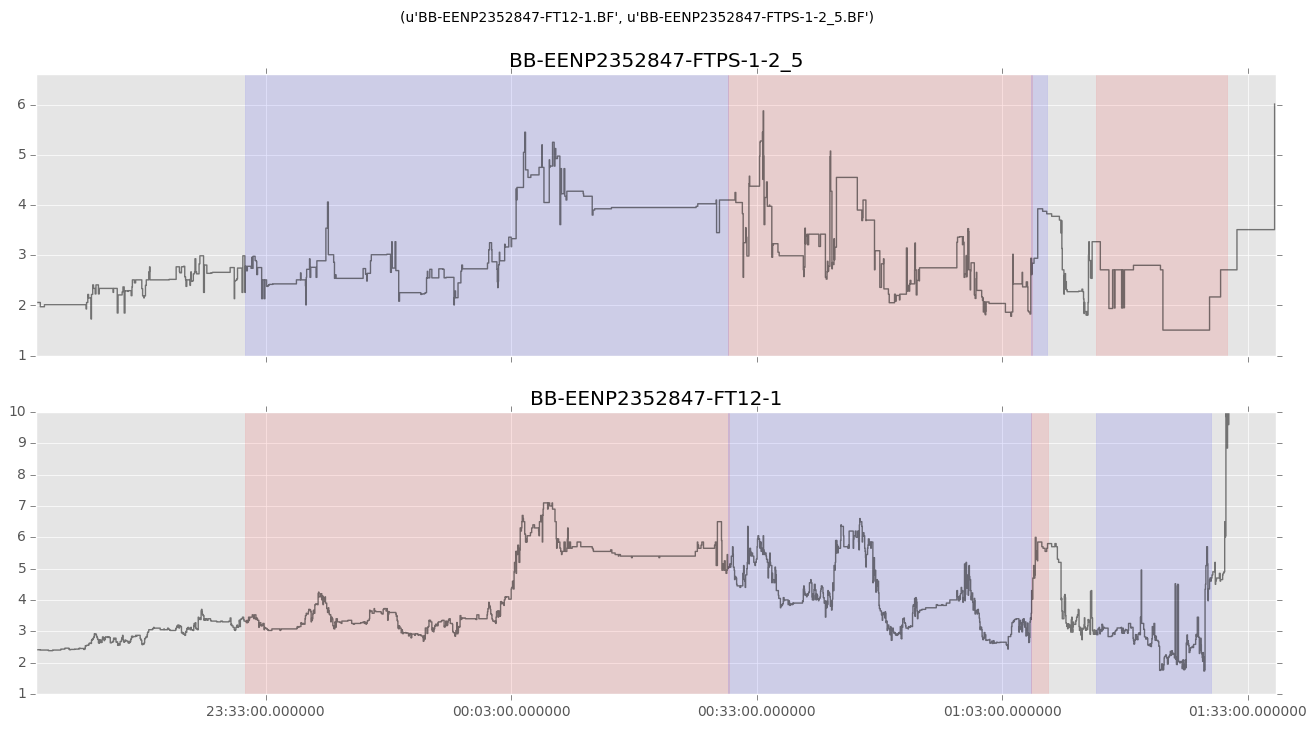

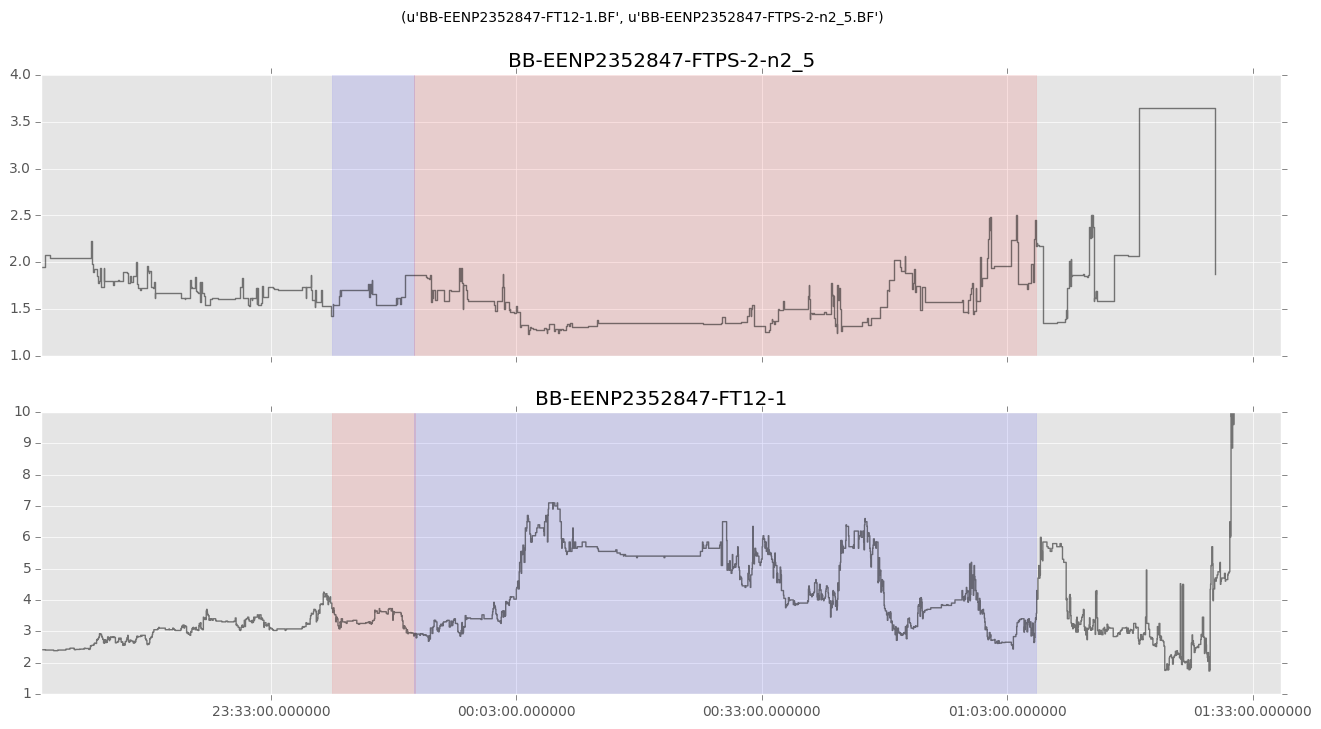

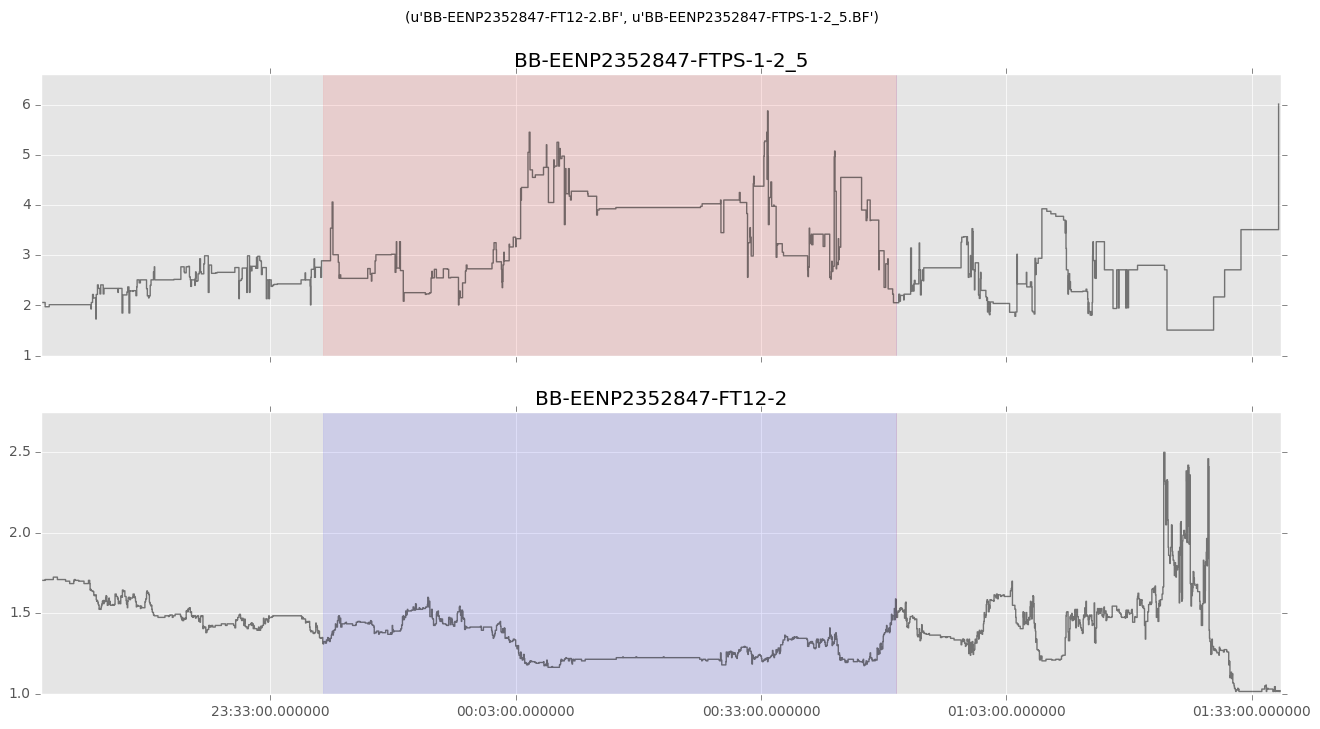

In [328]:
for pk in df.pair_key.unique()[:50]:
    do_plot(pk)